# SPE Gulf Coast Section ML Challenge

By Jeremy Zhao
Date: February 25, 2021

This is my second machine learning submission. This challenge was to take data provided by the SPE Gulf Coast group to predict the DTSM sonic log from well logs. The particular challenge in this was that there were very few opportunities to a leaderboard, and the fact that I am not well versed in well logs. 

This Jupyter notebook draws on previous notebooks I've developed, notebooks provided during the webinar sessions hosted by SPE.

Some URLs for reference:

https://towardsdatascience.com/handling-big-volume-of-well-log-data-with-a-boosted-time-efficiency-with-python-dfe0319daf26

## Credit Information

Some of the front end data exploration is based off of the Jupyter notebook by Dr. Babak Akbari found here: https://github.com/babak2520/SPE-GCS-ML-Challenge-1/tree/master

Lots of resources from the XEEK were used and leveraged to build this notebook:

https://xeek.ai/challenges/force-well-logs/data

https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

I am also referencing my own final FORCE Lithology 2020 Challenge Notebook as some items were taken from there as well:

https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition/tree/master/lithology_competition/code/JeremyZhao


### 1A. Loading Required Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import lasio
import os
import numpy as np
import pandas as pd
# import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import power_transform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor

# import tensorflow as tf
# tf.set_random_seed(42)

import featuretools as ft

# import xgboost as xgb

import lightgbm as lgb

import time
import operator

pd.set_option('max_columns', None)

### 1B. Version Control

In [2]:
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Sklearn version: {sklearn.__version__}')
print(f'LightGBM version is: {lgb.__version__}')

Pandas version: 1.2.1
Numpy version: 1.19.2
Matplotlib version: 3.3.2
Sklearn version: 0.23.2
LightGBM version is: 3.1.1


### 2A. Import LAS Data

In [3]:
# Timing of dictionary creation
start_time = time.time()

lasDic = {}
well_list = pd.DataFrame(columns=['NO', 'WELL'])
wellno = 0

for filename in os.listdir('files/')[:]:
    lasDic[filename] = lasio.read('files/' + filename)
    well_list = well_list.append({'NO' : wellno , 'WELL' : filename}, ignore_index=True)
    wellno += 1
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 275.34273195266724 seconds ---


In [4]:
counter = 0
for filename in lasDic:
    las = lasDic[filename]
    print(counter)
    print(filename)
    print(las.curves)
    counter +=1 

0
0052442d0162_TGS.las
Mnemonic  Unit  Value  Description               
--------  ----  -----  -----------               
DEPT      F            1 MEASURED DEPTH          
DTCO      US/F         DELTA-T COMPRESSIONAL     
GRS       GAPI         GAMMA RAY FROM SONIC LOG  
DTSM      US/F         DELTA-T SHEAR             
1
00a60e5cc262_TGS.las
Mnemonic  Unit  Value  Description                                                 
--------  ----  -----  -----------                                                 
DEPT      F                                                                        
HLLD      OHMM         LATEROLOG DEEP RES.                                         
HLLS      OHMM         LATEROLOG SHALLOW RES.                                      
RXOZ      OHMM         FLUSHED ZONE RESISTIVITY                                    
GRR       GAPI         GAMMA RAY FROM RES.                                         
GRD       GAPI         GAMMA RAY FROM DENSITY LOG                 

In [5]:
well_list

,NO,WELL
0,0,0052442d0162_TGS.las
1,1,00a60e5cc262_TGS.las
2,2,01c726e0fabe_TGS.las
3,3,02571837c35f_TGS.las
4,4,03d4fc789db8_TGS.las
...,...,...
229,229,fb82f07561bd_TGS.las
230,230,fc913430daa9_TGS.las
231,231,fcd64679cafa_TGS.las
232,232,fe47e0c3ac55_TGS.las


In [6]:
len(lasDic)

234

In [7]:
curveCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[0] in curveCount.keys():
            curveCount[item[0]] += 1
        else:
            curveCount[item[0]] = 1

In [8]:
len(curveCount)

291

In [9]:
print(curveCount)

{'DEPT': 234, 'DTCO': 223, 'GRS': 60, 'DTSM': 234, 'HLLD': 8, 'HLLS': 8, 'RXOZ': 43, 'GRR': 74, 'GRD': 75, 'RHOZ': 87, 'TNPH': 15, 'DPHZ': 15, 'HCAL': 17, 'HDRA': 91, 'PEFZ': 104, 'DTLF': 4, 'DTLN': 3, 'PR': 9, 'VPVS': 10, 'SGRDD': 21, 'TNPH_LS': 77, 'PXND': 2, 'RLA3': 44, 'CALD': 92, 'DPHZ_LS': 79, 'AO30': 2, 'CALR': 15, 'SPR': 89, 'AT30': 48, 'AT90': 44, 'AT10': 39, 'AT20': 26, 'HCALR': 29, 'SPHI_LS': 32, 'TENR': 42, 'TENS': 43, 'AT60': 26, 'HSGR': 6, 'TNPH_LIM': 1, 'ILD': 40, 'ILM': 39, 'SFLU': 39, 'SFLA': 8, 'CILD': 15, 'NPHI_LS': 47, 'NPOR_LS': 5, 'HCALD': 32, 'AE20': 2, 'AE30': 4, 'AE90': 4, 'DTRP': 12, 'DTRS': 12, 'RHOB': 73, 'TEND': 41, 'ILD1': 1, 'PEF': 54, 'DRHO': 69, 'NPHI': 50, 'DPHI': 37, 'CALI': 5, 'CALI_1': 1, 'CALI_2': 1, 'CGR': 4, 'DPHI_LS': 31, 'ECGR': 2, 'ECGRR': 4, 'GR': 11, 'GR_1': 1, 'HCAL_1': 5, 'HCAL_2': 3, 'TBIT20': 4, 'TBIT30': 4, 'TBIT60': 3, 'TBIT90': 4, 'TEN': 5, 'DTMD': 1, 'AFCO': 2, 'ECGRS': 10, 'HD2_PPC1': 1, 'PYR': 1, 'VPVS_X': 1, 'VPVS_Y': 1, 'DTTP': 2

### 2B. Load final 20 well LAS test data

In [10]:
# Timing of dictionary creation
start_time = time.time()

lastestDic = {}
for filename in os.listdir('final_test/')[:]:
    lastestDic[filename] = lasio.read('final_test/' + filename)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.181155681610107 seconds ---


In [11]:
for filename in lastestDic:
    lastest = lastestDic[filename]
    print(filename)
    print(lastest.curves)
    print(lastest.data.shape)

00d02be79f49_TGS.las
Mnemonic  Unit  Value  Description                                               
--------  ----  -----  -----------                                               
DEPT      F            1 MEASURED DEPTH                                          
DPHI_LS   DEC          DENSITY POROSITY LIMESTONE                                
NPHI_LS   DEC          NEUTRON POROSITY LIMESTONE                                
DRHO      G/C3         BULK DENSITY CORRECTION                                   
PEF       B/E          PHOTOELECTRIC FACTOR                                      
CALD      IN           CALIPER FROM DENSITY LOG                                  
RHOB      G/C3         BULK DENSITY                                              
GRR       GAPI         GAMMA RAY FROM RESISTIVITY LOG                            
ILD       OHMM         INDUCTION DEEP RESISTIVITY                                
ILM       OHMM         INDUCTION MEDIUM RESISTIVITY                          

### 3. Mneumonics Count

Here we are using the example from Dr. Akbari to see how many wells have data on a particular mneumonic. 

In [12]:
mn_count = pd.DataFrame(curveCount, index=[0]).transpose()

In [13]:
mn_count.reset_index(inplace=True)
mn_count.sort_values(by=[0], inplace=True, ascending=False)
mn_count.rename(columns={"index": "Mneumonic", 0: "Count"}, inplace=True)
mn_count30 = mn_count.head(30)
mn_count30

,Mneumonic,Count
0,DEPT,234
3,DTSM,234
1,DTCO,223
14,PEFZ,104
23,CALD,92
13,HDRA,91
27,SPR,89
9,RHOZ,87
24,DPHZ_LS,79
20,TNPH_LS,77


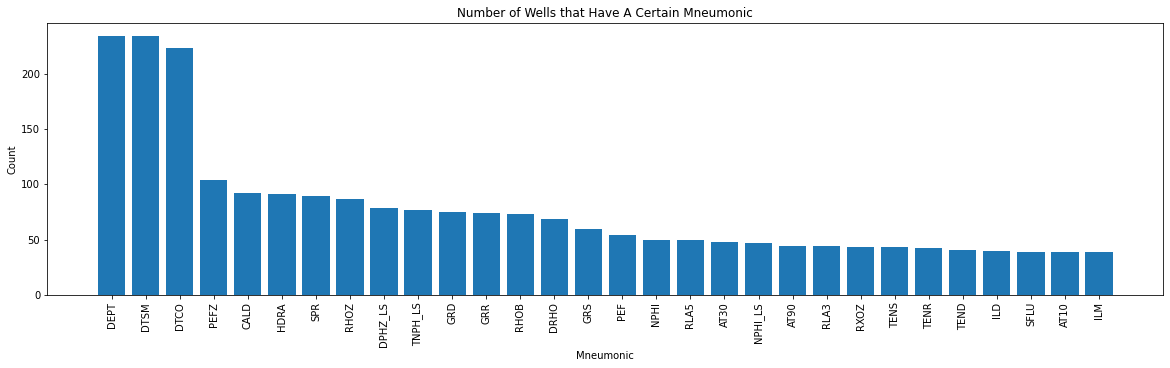

In [14]:
plt.figure(figsize=(20, 5))
plt.bar(mn_count30['Mneumonic'],mn_count30['Count'])
plt.xlabel('Mneumonic')
plt.ylabel('Count')
plt.title('Number of Wells that Have A Certain Mneumonic')
plt.xticks(rotation=90)
plt.show()

## 4. Exploratory Data Analysis

### 4A. Set up Initial DataFrame

In [15]:
las_df = pd.DataFrame()

In my limited research, the following variables were the same so they were renamed as to reduce the number of columns I had to deal with. 
Of particular interest in my initial research were the 'DRH' and 'AHT30' which I thought were really synonymous with 'DRHO' and 'AT30' respectively

In [16]:
renaminglist = {'DRH':'DRHO', 'AHT30': 'AT30'}

The following variables were taken based on how many times they are present in the LAS files. 

In [17]:
important_cols = ['DEPT', 'DTSM', 'DTCO', 'PEF_1', 'CALD', 'HDRA', 'SPR', 'RHOZ', 'DPHZ_LS', 'TNPH_LS', 
                  'GRD', 'GRR', 'GRS', 'RHOB', 'DRHO', 'NPHI', 'NPHI_LS', 'CALR', 'ILD', 'ILM', 'HLLD', 'LLS', 'HCAL', 'AT30',
                 'RLA5', 'AT90', 'RLA3', 'RXOZ', 'TENS', 'TENR', 'TEND', 'SFLU', 'AT10']

The following script renames the DRH and AHT30 respectively, but also amalgamates PEFZ or PEF as PEF_1 instead. From my investigation, this allowed me to reduce my columns and also concat the PEF readings together

In [18]:
# Timing of dataframe creation
start_time = time.time()

for well in lasDic:
    las = lasDic[well]
    lasdf = las.df()
    lasdf.reset_index(inplace=True)
    
    for col in lasdf.columns:
        if col in list(renaminglist.keys()):
            lasdf = lasdf.rename(columns = {col:renaminglist[col]})

    if all(elem in lasdf.columns for elem in ['PEFZ', 'PEF']):
#         print('PEF and PEFZ present')
        lasdf['PEF_1'] = ""
        lasdf['PEF_1'] = lasdf.apply(lambda x: x['PEFZ'] if pd.isnull(x['PEF']) else x['PEF'], axis=1)
    elif 'PEFZ' in lasdf.columns:
#         print('PEFZ present')
        lasdf['PEF_1'] = ""
        lasdf['PEF_1'] = lasdf.apply(lambda x: x['PEFZ'], axis=1)
    elif 'PEF' in lasdf.columns:
#         print('PEF present')
        lasdf['PEF_1'] = ""
        lasdf['PEF_1'] = lasdf.apply(lambda x: x['PEF'], axis=1)
    else:
#         print('None present')
        lasdf['PEF_1'] = np.nan
            
    lasdf = lasdf[lasdf.columns.intersection(important_cols)]
    lasdf.insert(loc=0, column='WELL', value=well)
    lasdf.insert(loc=1, column='LAT', value=las.well['SLAT'].value)
    lasdf.insert(loc=2, column='LONG', value=las.well['SLON'].value)
    las_df = pd.concat([las_df, lasdf], ignore_index=True, sort=False)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 364.7321059703827 seconds ---


### 4B. Boxplot Review

The boxplots helped figure out where there were outliers, and datapoints that would benefit from applying a logathrim to it.

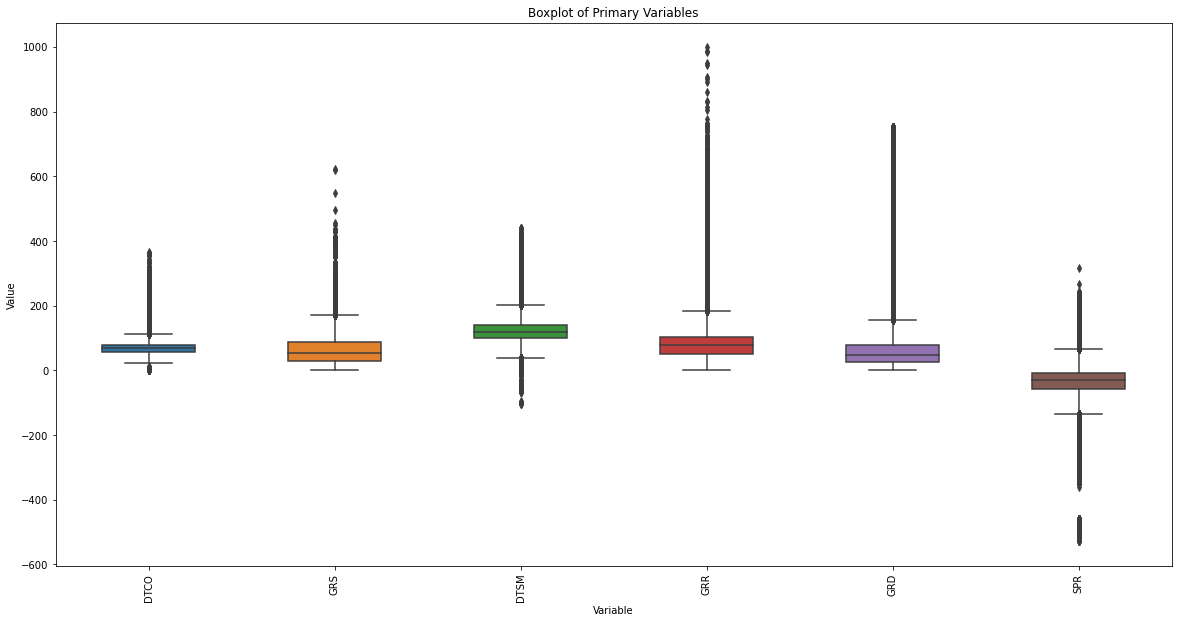

In [19]:
las_df_boxplot = pd.melt(las_df[['DTCO', 'GRS', 'DTSM', 'GRR', 'GRD', 'SPR']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot["variable"], y=las_df_boxplot["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

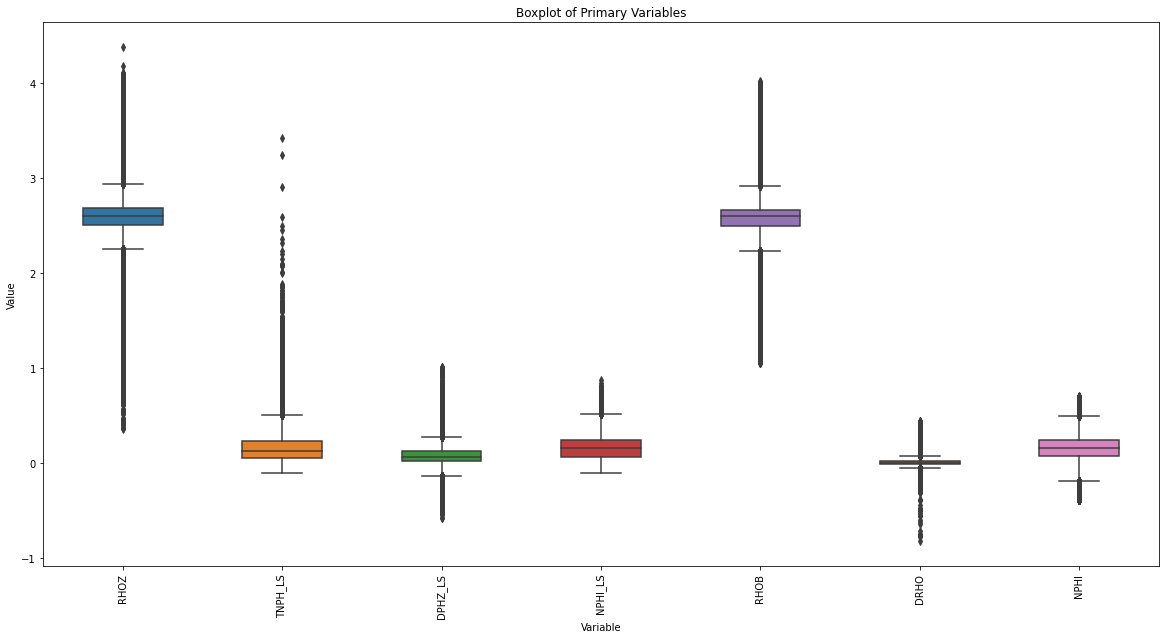

In [20]:
las_df_boxplot2 = pd.melt(las_df[['RHOZ', 'TNPH_LS', 'DPHZ_LS', 'NPHI_LS', 'RHOB', 'DRHO', 'NPHI']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot2["variable"], y=las_df_boxplot2["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

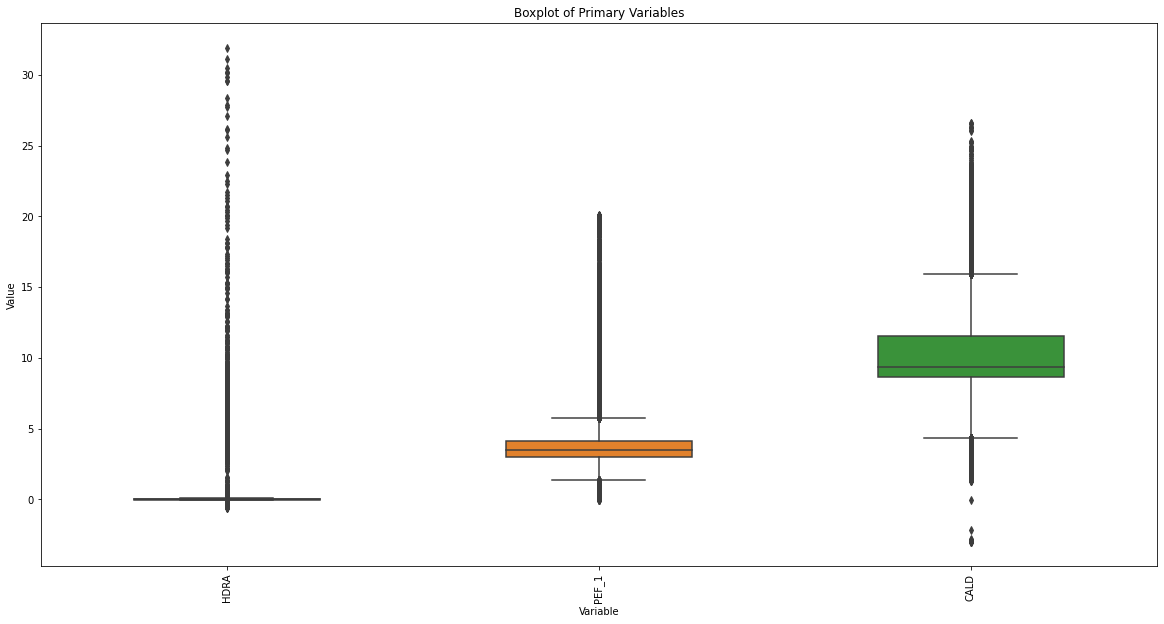

In [21]:
las_df_boxplot2a = pd.melt(las_df[['HDRA', 'PEF_1', 'CALD']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot2a["variable"], y=las_df_boxplot2a["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

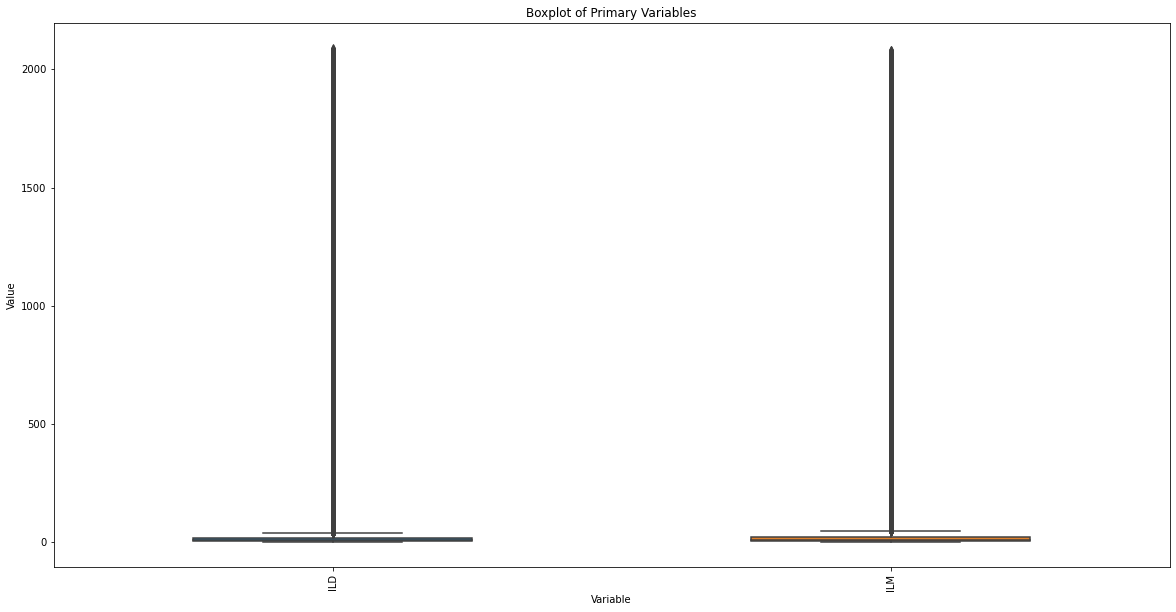

In [22]:
las_df_boxplot3 = pd.melt(las_df[['ILD', 'ILM']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot3["variable"], y=las_df_boxplot3["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

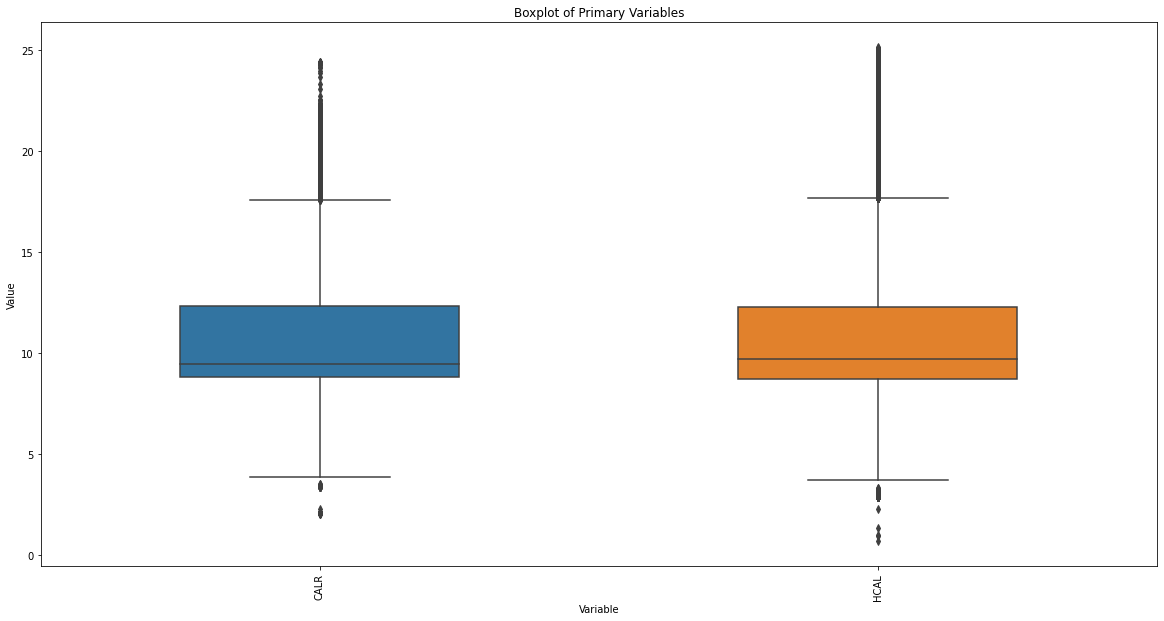

In [23]:
las_df_boxplot4 = pd.melt(las_df[['CALR', 'HCAL']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot4["variable"], y=las_df_boxplot4["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

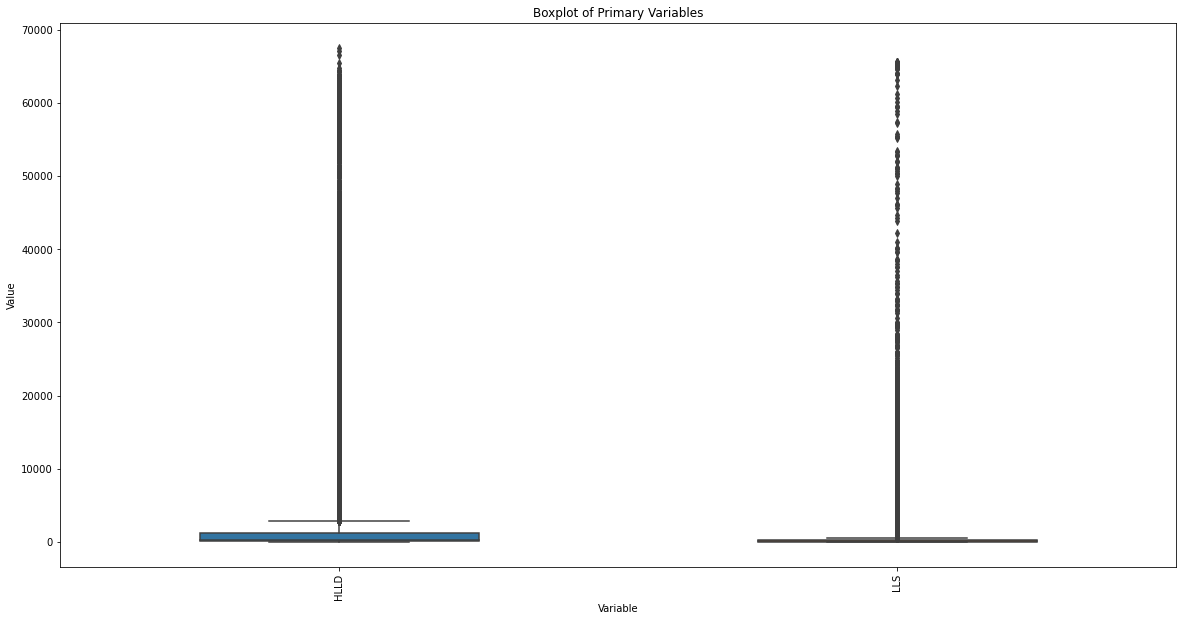

In [24]:
las_df_boxplot5 = pd.melt(las_df[['HLLD', 'LLS']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot5["variable"], y=las_df_boxplot5["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

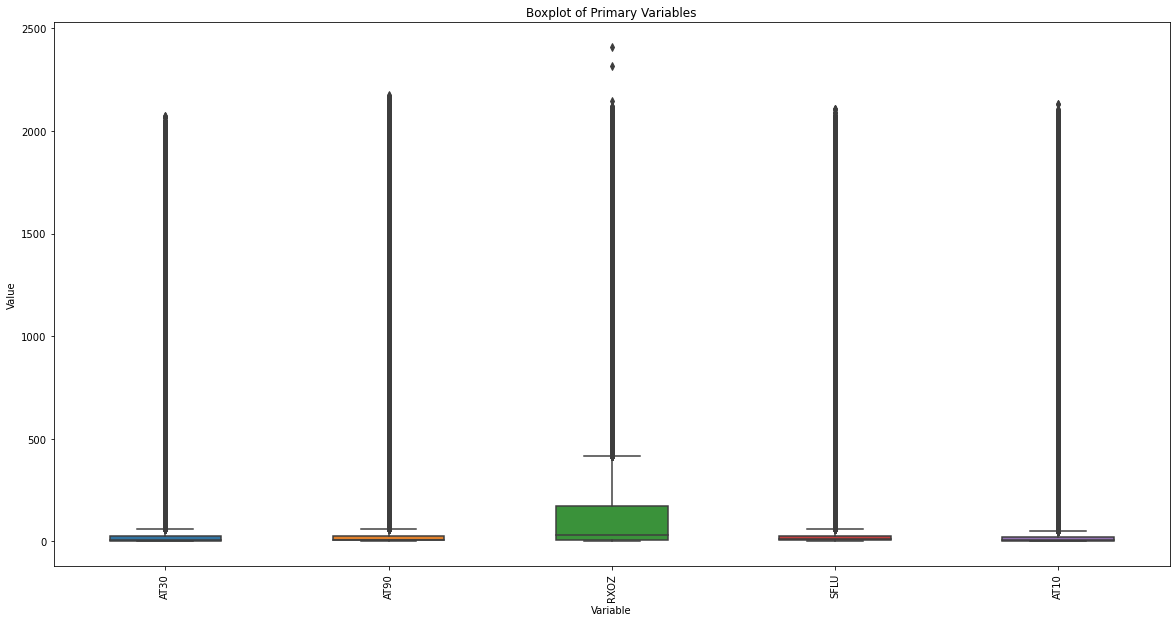

In [25]:
las_df_boxplot6 = pd.melt(las_df[['AT30', 'AT90', 'RXOZ', 'SFLU', 'AT10']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot6["variable"], y=las_df_boxplot6["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

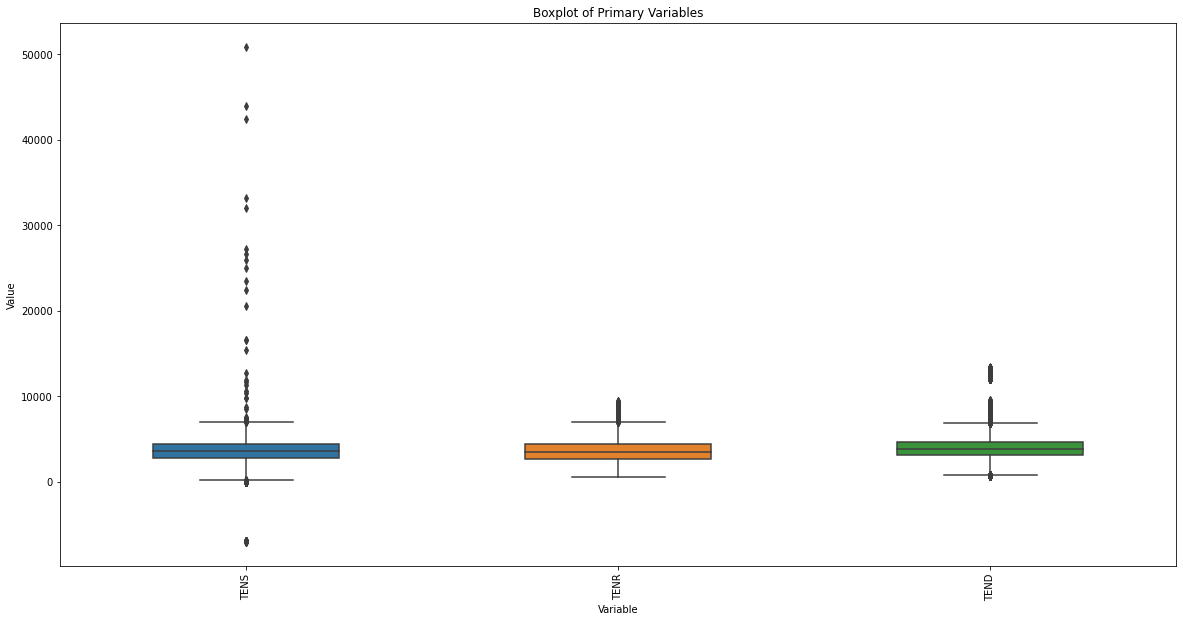

In [26]:
las_df_boxplot7 = pd.melt(las_df[['TENS', 'TENR', 'TEND']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot7["variable"], y=las_df_boxplot7["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

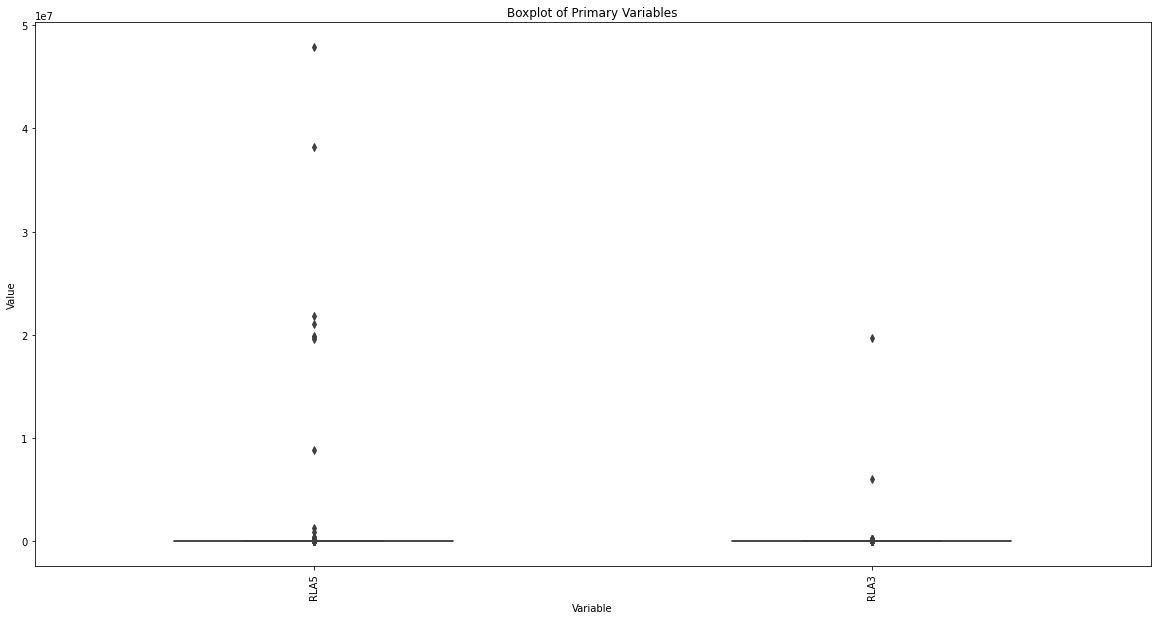

In [27]:
las_df_boxplot8 = pd.melt(las_df[['RLA5', 'RLA3']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot8["variable"], y=las_df_boxplot8["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

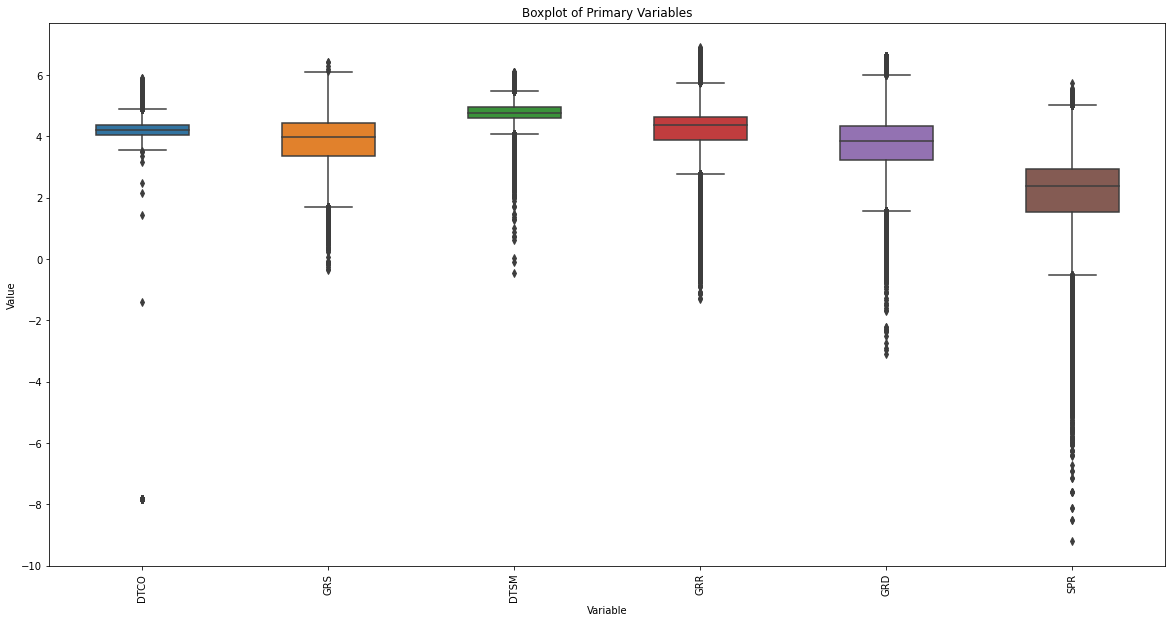

In [28]:
las_df_boxplot_log = pd.melt(np.log(las_df[['DTCO', 'GRS', 'DTSM', 'GRR', 'GRD', 'SPR']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot_log["variable"], y=las_df_boxplot_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

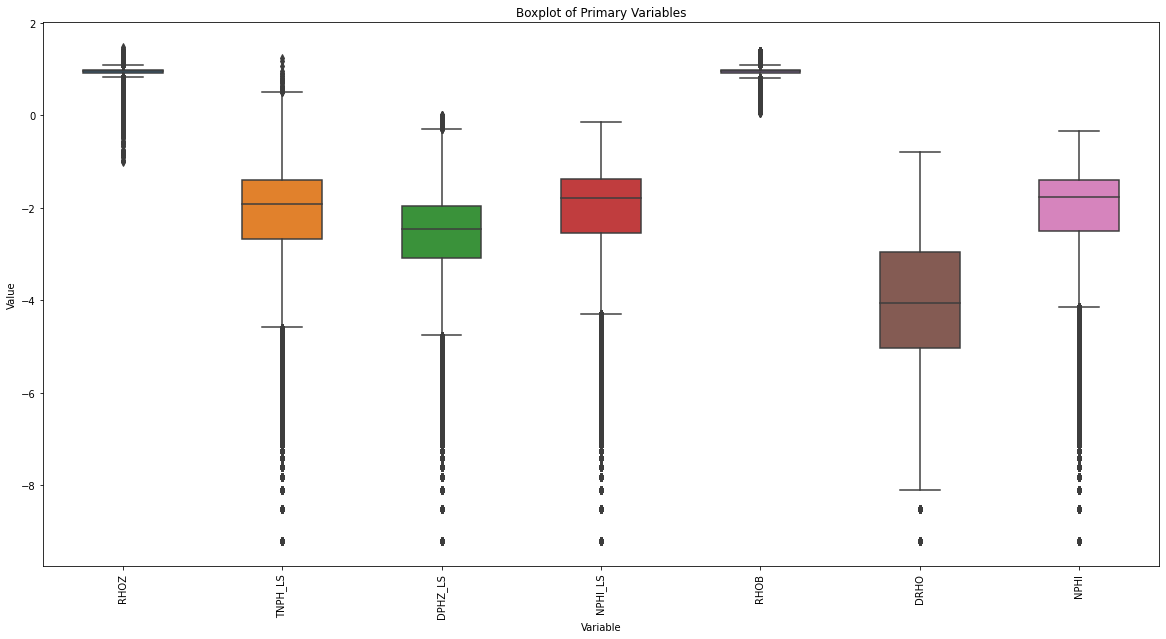

In [29]:
las_df_boxplot2_log = pd.melt(np.log(las_df[['RHOZ', 'TNPH_LS', 'DPHZ_LS', 'NPHI_LS', 'RHOB', 'DRHO', 'NPHI']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot2_log["variable"], y=las_df_boxplot2_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

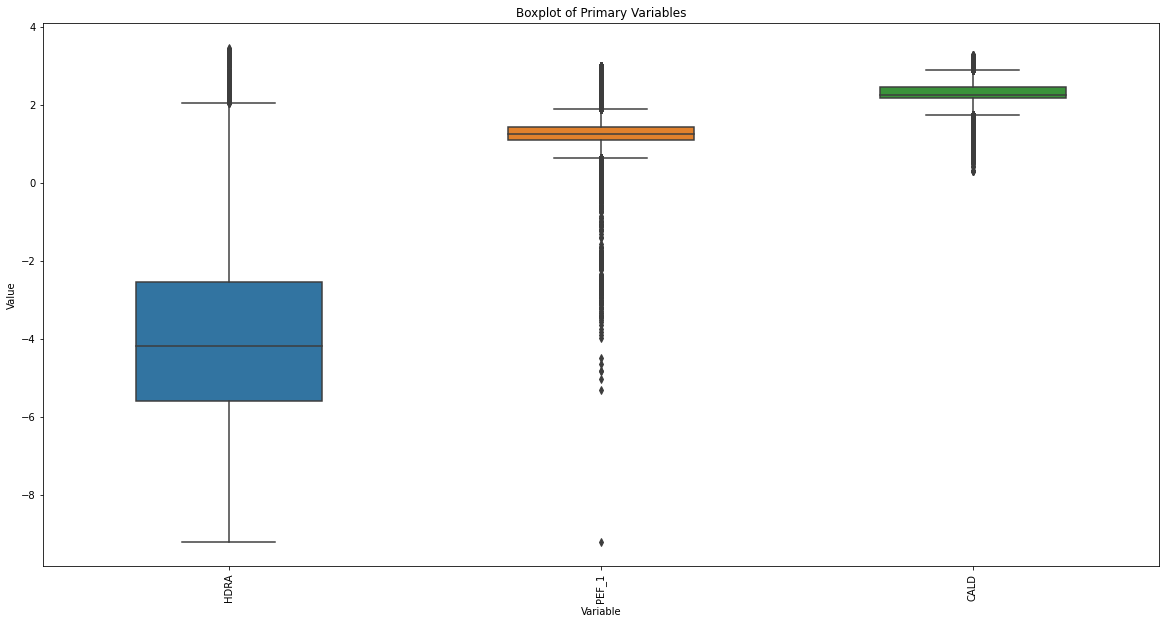

In [30]:
las_df_boxplot2a_log = pd.melt(np.log(las_df[['HDRA', 'PEF_1', 'CALD']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot2a_log["variable"], y=las_df_boxplot2a_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

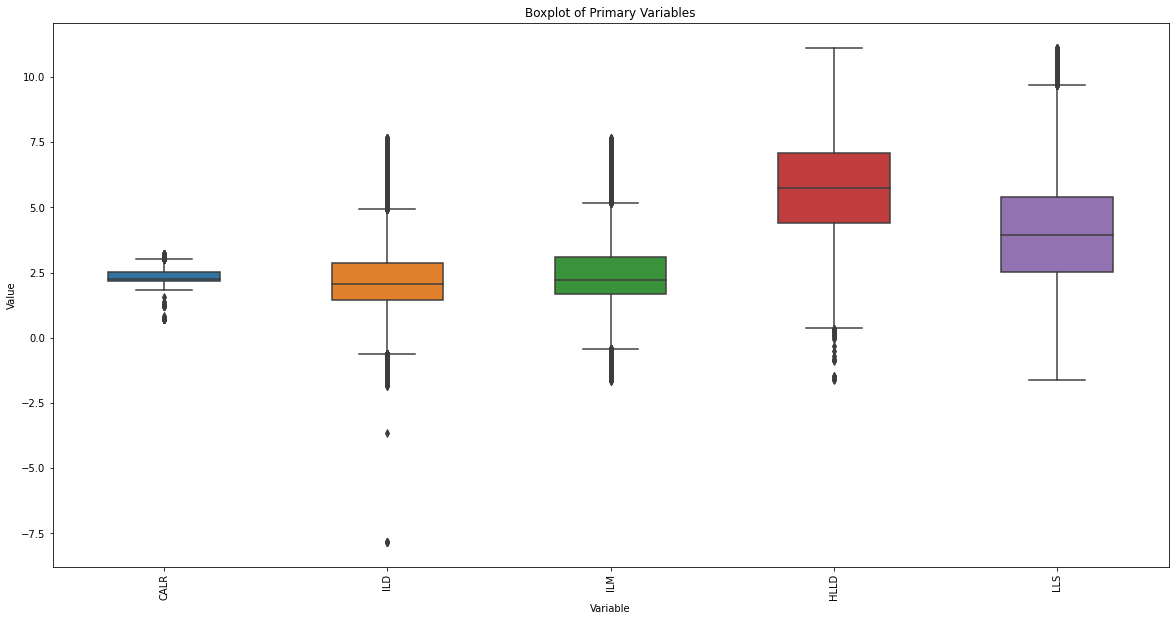

In [31]:
las_df_boxplot3_log = pd.melt(np.log(las_df[['CALR', 'ILD', 'ILM', 'HLLD', 'LLS']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot3_log["variable"], y=las_df_boxplot3_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

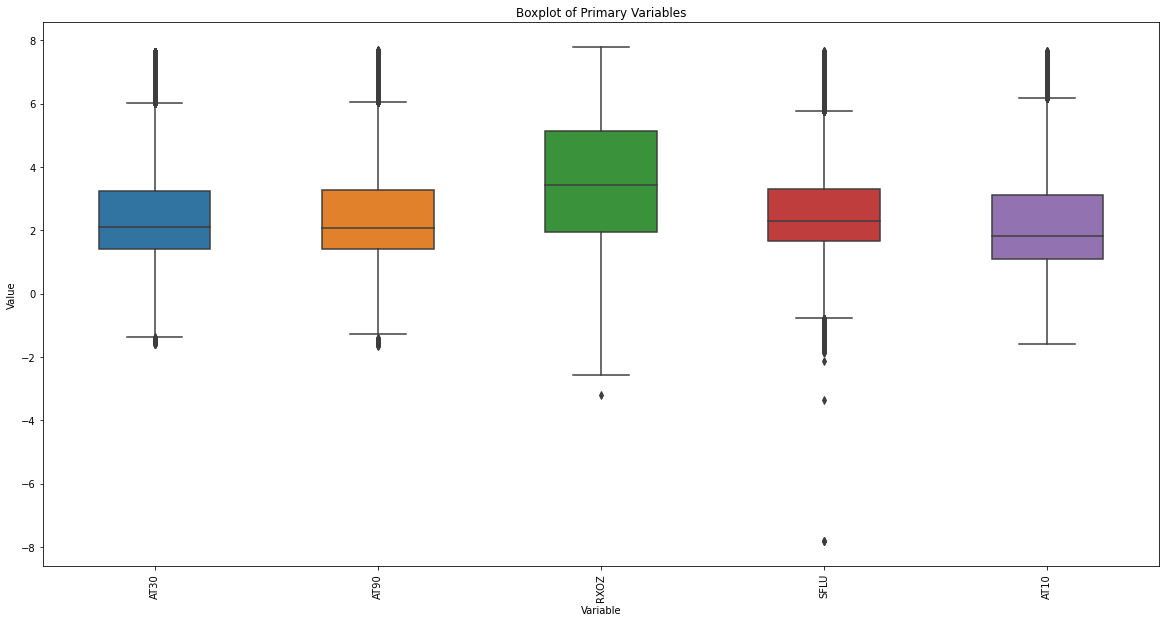

In [32]:
las_df_boxplot4_log = pd.melt(np.log(las_df[['AT30', 'AT90', 'RXOZ', 'SFLU', 'AT10']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot4_log["variable"], y=las_df_boxplot4_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

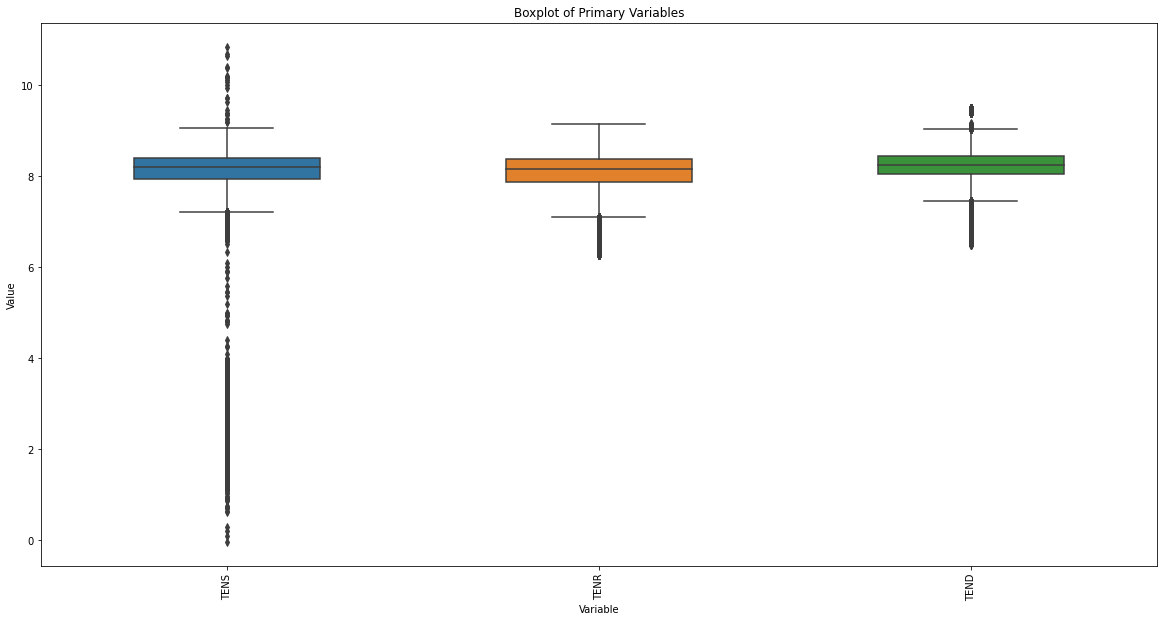

In [33]:
las_df_boxplot5_log = pd.melt(np.log(las_df[['TENS', 'TENR', 'TEND']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot5_log["variable"], y=las_df_boxplot5_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

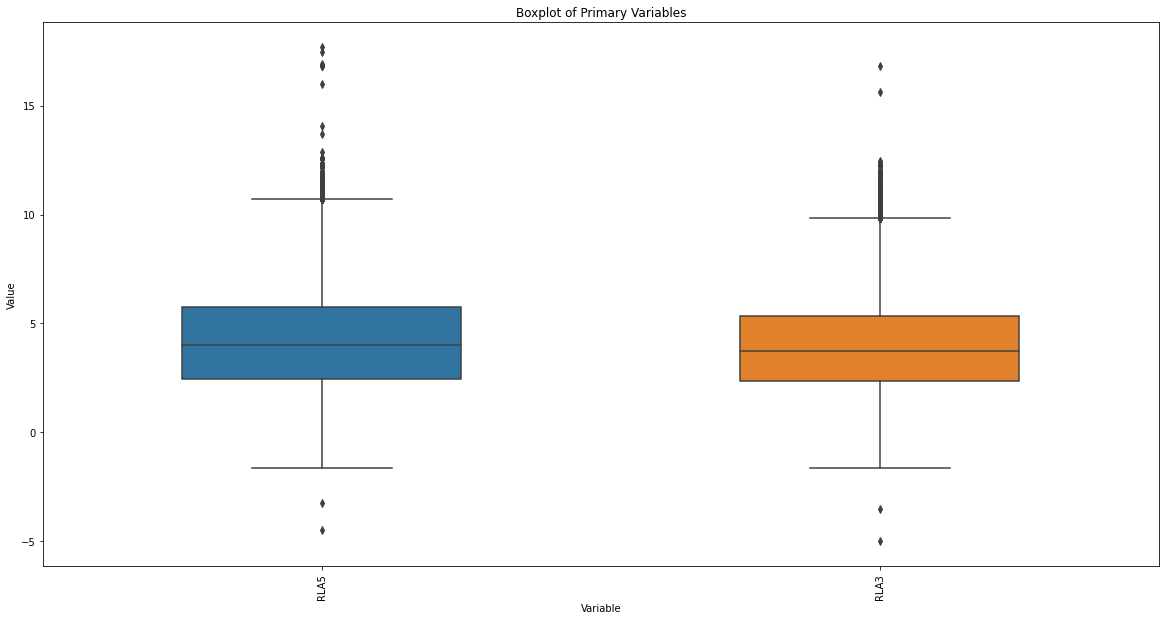

In [34]:
las_df_boxplot6_log = pd.melt(np.log(las_df[['RLA5', 'RLA3']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=las_df_boxplot6_log["variable"], y=las_df_boxplot6_log["value"], showfliers = True, width=0.5)
ax.set(xlabel='Variable', ylabel='Value')
ax.set_title("Boxplot of Primary Variables")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

### 5. Lat/Long K-Means Clustering

This method of clustering regions (which helped in the scoring with a random blind data wellset I pulled) is based on the following:

https://github.com/mycarta/Force-2020-Machine-Learning-competition_predict-lithology-EDA

In [35]:
Lat = []
Lon = []
Well = []
for filename in lasDic:
    las = lasDic[filename]
    Lat.append(las.well['SLAT'].value)
    Lon.append(las.well['SLON'].value)
    Well.append(filename)

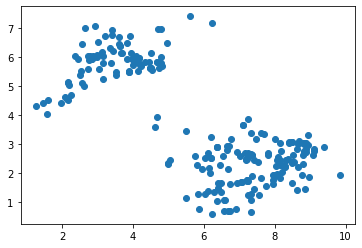

In [36]:
plt.scatter(x=Lon,y=Lat)
plt.show()

In [37]:
LatLong_df = pd.DataFrame(
    {'WELL': Well,
     'LAT': Lat,
     'LONG': Lon
    })

In [38]:
LatLong_df

,WELL,LAT,LONG
0,0052442d0162_TGS.las,1.678958,6.390539
1,00a60e5cc262_TGS.las,3.680670,7.095404
2,01c726e0fabe_TGS.las,2.763908,9.104955
3,02571837c35f_TGS.las,2.299873,5.807630
4,03d4fc789db8_TGS.las,1.404772,8.618104
...,...,...,...
229,fb82f07561bd_TGS.las,3.361701,7.688234
230,fc913430daa9_TGS.las,5.515475,2.537780
231,fcd64679cafa_TGS.las,2.048852,8.203397
232,fe47e0c3ac55_TGS.las,6.216308,3.438106


In [39]:
X = LatLong_df.drop(['WELL'], axis=1).values

In [40]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X)

In [41]:
len(labels)

234

In [42]:
cluster_df = LatLong_df.join(pd.DataFrame(labels, columns=['CLUSTER']))
cluster_df  = cluster_df .astype({"CLUSTER":'category'}) 

In [43]:
cluster_df 

,WELL,LAT,LONG,CLUSTER
0,0052442d0162_TGS.las,1.678958,6.390539,0
1,00a60e5cc262_TGS.las,3.680670,7.095404,0
2,01c726e0fabe_TGS.las,2.763908,9.104955,0
3,02571837c35f_TGS.las,2.299873,5.807630,0
4,03d4fc789db8_TGS.las,1.404772,8.618104,0
...,...,...,...,...
229,fb82f07561bd_TGS.las,3.361701,7.688234,0
230,fc913430daa9_TGS.las,5.515475,2.537780,1
231,fcd64679cafa_TGS.las,2.048852,8.203397,0
232,fe47e0c3ac55_TGS.las,6.216308,3.438106,1


In [44]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   WELL     234 non-null    object  
 1   LAT      234 non-null    float64 
 2   LONG     234 non-null    float64 
 3   CLUSTER  234 non-null    category
dtypes: category(1), float64(2), object(1)
memory usage: 6.0+ KB


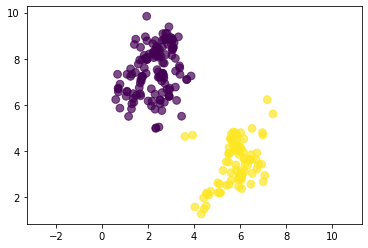

In [45]:
ax = plt.gca()
ax.axis('equal')
ax.scatter(X[:, 0], X[:, 1], c = labels, s=60, cmap='viridis', zorder=1, alpha = 0.7)

### 6A. More EDA

Here we merge our large dataframe with the K-means lat/long dataframe I made earlier. 

In [46]:
las_df = las_df.merge(cluster_df, how='inner', on=['WELL', 'LAT', 'LONG'])

In [47]:
las_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3782744 entries, 0 to 3782743
Data columns (total 37 columns):
 #   Column   Dtype   
---  ------   -----   
 0   WELL     object  
 1   LAT      float64 
 2   LONG     float64 
 3   DEPT     float64 
 4   DTCO     float64 
 5   GRS      float64 
 6   DTSM     float64 
 7   PEF_1    float64 
 8   HLLD     float64 
 9   RXOZ     float64 
 10  GRR      float64 
 11  GRD      float64 
 12  RHOZ     float64 
 13  HCAL     float64 
 14  HDRA     float64 
 15  TNPH_LS  float64 
 16  RLA3     float64 
 17  CALD     float64 
 18  DPHZ_LS  float64 
 19  CALR     float64 
 20  SPR      float64 
 21  AT30     float64 
 22  AT90     float64 
 23  AT10     float64 
 24  TENR     float64 
 25  TENS     float64 
 26  ILD      float64 
 27  ILM      float64 
 28  SFLU     float64 
 29  NPHI_LS  float64 
 30  RHOB     float64 
 31  TEND     float64 
 32  DRHO     float64 
 33  NPHI     float64 
 34  LLS      float64 
 35  RLA5     float64 
 36  CLUSTER 

The following is the normal procedure to see which columns have NaN values and how many of them there are. 

In [48]:
las_df.isna().any()

WELL       False
LAT        False
LONG       False
DEPT       False
DTCO        True
GRS         True
DTSM        True
PEF_1       True
HLLD        True
RXOZ        True
GRR         True
GRD         True
RHOZ        True
HCAL        True
HDRA        True
TNPH_LS     True
RLA3        True
CALD        True
DPHZ_LS     True
CALR        True
SPR         True
AT30        True
AT90        True
AT10        True
TENR        True
TENS        True
ILD         True
ILM         True
SFLU        True
NPHI_LS     True
RHOB        True
TEND        True
DRHO        True
NPHI        True
LLS         True
RLA5        True
CLUSTER    False
dtype: bool

In [49]:
las_df.isna().sum()

WELL             0
LAT              0
LONG             0
DEPT             0
DTCO       1864062
GRS        3147195
DTSM       1797698
PEF_1      2295175
HLLD       3702542
RXOZ       3328698
GRR        2629084
GRD        2809180
RHOZ       2849771
HCAL       3597127
HDRA       2814375
TNPH_LS    2568872
RLA3       3321271
CALD       2857381
DPHZ_LS    2936062
CALR       3654414
SPR        2571060
AT30       3215406
AT90       3314578
AT10       3418057
TENR       3271830
TENS       3323737
ILD        3184454
ILM        3311097
SFLU       3257226
NPHI_LS    3331739
RHOB       3203944
TEND       3268408
DRHO       3128664
NPHI       3347417
LLS        3659814
RLA5       3229072
CLUSTER          0
dtype: int64

In [50]:
las_df.shape

(3782744, 37)

### 6B. Make a duplicate copy

Making a duplicate copy so we can do multiple runs at a time while keeping the integrity of the original database developed.

In [51]:
las_df1 = las_df.copy()

## 7. Data Preparation

Based on the exploratory analysis and brute force testing, I've deemed the following variables to be of importance. There was also some consultation with other engineers who were more experienced in the field of geophysics and petrophysics in order to see what worked and what did not. 

In [52]:
final_vars = ['WELL', 'LAT', 'LONG', 'DEPT', 'GRD', 'CALD', 'HCAL', 'CALR', 'RHOB', 'RHOZ', 'NPHI', 'ILD', 'ILM', 'HLLD', 'LLS', 'SPR', 'PEF_1', 'DTCO', 
                   'DTSM', 'GRR', 'GRS', 'AT30', 'CLUSTER']

final_vars1 = ['LAT', 'LONG', 'DEPT', 'GRD', 'CALD', 'HCAL', 'CALR', 'RHOB', 'RHOZ', 'NPHI', 'ILD', 'ILM', 'HLLD', 'LLS', 'SPR', 'PEF_1', 'DTCO', 
               'GRR', 'GRS', 'AT30', 'CLUSTER']

las_df1 = las_df1[final_vars]

### 7A. Treating Outliers

The following limits will be used to better capture the valid values of each variable that are being examined based on my previous ML challenges and looking at sample logs and ranges for well logs.

- Gamma Ray will not exceed over 200 for GRS, GRR, and GRD
- ILM and ILD will also have a limit of 200
- HLLD will have a limit of 5000
- LLS will have a limit of 1000

Given the above limits, some of the outliers that do not conform with the limits will be turned to NaN and then those values will be treated again later.

The following function will help us treat the outliers that do not conform to the restrictions. This will use the operator module in Python as well.

In [53]:
def outlier_removal(df, op, limit, replace):
    temp_name = df.name
    print('Before outlier removal for',df.name)
    print(df.name,'Min',min(df[df.notnull()]))
    print(df.name,'Max',max(df[df.notnull()]))
    outliers = [x for x in df if op(x,limit)]
    print('Number of',df.name,'outliers:',len(outliers),'\n')
    
    df = np.where((op(df,limit)), replace, df)
    df = pd.Series(df)
    print('After outlier removal for',temp_name)
    print(temp_name,'Min',min(df[df.notnull()]))
    print(temp_name,'Max',max(df[df.notnull()]))
    
    return df

In [54]:
las_df1['GRS'] = outlier_removal(las_df1['GRS'], operator.gt, 200, 200)

Before outlier removal for GRS
GRS Min 0.6972
GRS Max 621.4491
Number of GRS outliers: 2206 

After outlier removal for GRS
GRS Min 0.6972
GRS Max 200.0


In [55]:
las_df1['GRR'] = outlier_removal(las_df1['GRR'], operator.gt, 200, 200)

Before outlier removal for GRR
GRR Min 0.2714
GRR Max 998.6257
Number of GRR outliers: 5163 

After outlier removal for GRR
GRR Min 0.2714
GRR Max 200.0


In [56]:
las_df1['GRD'] = outlier_removal(las_df1['GRD'], operator.gt, 200, 200)

Before outlier removal for GRD
GRD Min -0.3915
GRD Max 750.9111
Number of GRD outliers: 21135 

After outlier removal for GRD
GRD Min -0.3915
GRD Max 200.0


In [57]:
las_df1['ILM'] = outlier_removal(las_df1['ILM'], operator.gt, 200, 200)

Before outlier removal for ILM
ILM Min 0.191
ILM Max 2084.436
Number of ILM outliers: 20199 

After outlier removal for ILM
ILM Min 0.191
ILM Max 200.0


In [58]:
las_df1['ILD'] = outlier_removal(las_df1['ILD'], operator.gt, 200, 200)

Before outlier removal for ILD
ILD Min 0.0004
ILD Max 2091.1938
Number of ILD outliers: 24588 

After outlier removal for ILD
ILD Min 0.0004
ILD Max 200.0


In [59]:
las_df1['HLLD'] = outlier_removal(las_df1['HLLD'], operator.gt, 5000, 5000)

Before outlier removal for HLLD
HLLD Min 0.1993
HLLD Max 67574.9297
Number of HLLD outliers: 6911 

After outlier removal for HLLD
HLLD Min 0.1993
HLLD Max 5000.0


In [60]:
las_df1['LLS'] = outlier_removal(las_df1['LLS'], operator.gt, 1000, 1000)

Before outlier removal for LLS
LLS Min 0.1984
LLS Max 65674.2955
Number of LLS outliers: 11643 

After outlier removal for LLS
LLS Min 0.1984
LLS Max 1000.0


### 7B. Log Transformations

Some of the data as previously explored with the boxplots will better work in a logarithmic scale. 

In [61]:
#No log transformation for DTSM, PEF, PEFZ, PEF_1, CALD, RHOZ, RHOB, CALR, HCAL, TENS, TENR, TEND

for column in las_df1[['DTCO', 'GRD', 'SPR', 'RHOZ', 
                      'NPHI', 'HLLD', 'LLS',
                      'GRR', 'GRS', 'AT30']]:
    las_df1[column] = np.log(las_df1[column])

In [62]:
las_df1

,WELL,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,DTSM,GRR,GRS,AT30,CLUSTER
0,0052442d0162_TGS.las,1.678958,6.390539,3495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.023024,99.2372,NaN,2.412623,NaN,0
1,0052442d0162_TGS.las,1.678958,6.390539,3495.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.027000,102.2765,NaN,2.263678,NaN,0
2,0052442d0162_TGS.las,1.678958,6.390539,3496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.031433,103.0520,NaN,2.237951,NaN,0
3,0052442d0162_TGS.las,1.678958,6.390539,3496.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.036009,99.3307,NaN,2.349535,NaN,0
4,0052442d0162_TGS.las,1.678958,6.390539,3497.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.040722,95.6763,NaN,2.443208,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3782739,fe8ab5538224_TGS.las,2.824751,8.884746,8457.0,NaN,8.6132,NaN,NaN,NaN,1.009963,NaN,NaN,NaN,NaN,NaN,NaN,5.0568,NaN,NaN,NaN,NaN,NaN,0
3782740,fe8ab5538224_TGS.las,2.824751,8.884746,8457.5,NaN,8.5873,NaN,NaN,NaN,1.012037,NaN,NaN,NaN,NaN,NaN,NaN,5.1065,NaN,NaN,NaN,NaN,NaN,0
3782741,fe8ab5538224_TGS.las,2.824751,8.884746,8458.0,NaN,8.5613,NaN,NaN,NaN,1.006899,NaN,NaN,NaN,NaN,NaN,NaN,5.1563,NaN,NaN,NaN,NaN,NaN,0
3782742,fe8ab5538224_TGS.las,2.824751,8.884746,8458.5,NaN,8.5354,NaN,NaN,NaN,1.000669,NaN,NaN,NaN,NaN,NaN,NaN,5.2060,NaN,NaN,NaN,NaN,NaN,0


### 7C. Correcting infnity and negative infnity values

Some of the datapoints were either infinity or negative infnity and had to just be forced corrected to zero for the purposes of this machine learning exercise. 

In [63]:
las_df1 = las_df1.replace([np.inf, -np.inf], 0)

### 7D. Blind Data Segregation

A random well was taken away from the training set to be used as a blind data test given that the scoring opportunities on the leaderboard were so limited. 

In [64]:
# Remove a single well to use as a blind test later

wellno = [219]

blind_data = pd.DataFrame()
og_blind_data = pd.DataFrame()

for well in wellno:
    blind_data_well = well_list.iloc[well]['WELL'] 
    blind_data_temp = las_df1[las_df1.WELL == blind_data_well]
    blind_data = pd.concat([blind_data, blind_data_temp], ignore_index=False, sort=False)
    og_blind_data_temp = las_df[las_df.WELL == blind_data_well]
    og_blind_data = pd.concat([og_blind_data, og_blind_data_temp], ignore_index=False, sort=False)
    las_df1 = las_df1[las_df1.WELL != blind_data_well]

### 7E. Imputing

Imputing everything except missing DTSMs from the training set did not improve the score. However, imputing DTSM when there were blank values in the training set actually improved the scoring on the blind data set. The decision was to impute all the values anyways, but the process takes longer.

In [65]:
def well_nan_remove(ref_df):
    """Impute each well rather than for the entire dataset.
    
    Args:
        ref_df (int): This is the well log dataset
    
    Returns:
        temp_df_1 (dataframe): The temporary dataframe made for this function
    """
    global las_df1
    temp_df_1 = pd.DataFrame()
    for well in ref_df['WELL'].unique():
        temp_X = ref_df[ref_df['WELL'] == well]
        temp_X = temp_X.drop(columns=['WELL'])
        for column in temp_X:
            if temp_X[column].isnull().all():
                temp_X.fillna(0, inplace=True)        
#         display(temp_X)
        imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending', random_state=42)
        imputer.fit(temp_X)
        temp_imputer = imputer.transform(temp_X)
#         temp_imputer = pd.DataFrame(temp_imputer)
        temp_imputer = pd.DataFrame(temp_imputer, columns=temp_X.columns)
        temp_df_1 = temp_df_1.append(temp_imputer, ignore_index=True)
#         display(temp_df_1)
    return temp_df_1

In [66]:
las_df1 = well_nan_remove(las_df1)

In [67]:
las_df1

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,DTSM,GRR,GRS,AT30,CLUSTER
0,1.678958,6.390539,3495.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.023024,99.2372,0.0,2.412623,0.0,0.0
1,1.678958,6.390539,3495.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.027000,102.2765,0.0,2.263678,0.0,0.0
2,1.678958,6.390539,3496.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.031433,103.0520,0.0,2.237951,0.0,0.0
3,1.678958,6.390539,3496.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.036009,99.3307,0.0,2.349535,0.0,0.0
4,1.678958,6.390539,3497.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.040722,95.6763,0.0,2.443208,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772038,2.824751,8.884746,8457.0,0.0,8.6132,0.0,0.0,0.0,1.009963,0.0,0.0,0.0,0.0,0.0,0.0,5.0568,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772039,2.824751,8.884746,8457.5,0.0,8.5873,0.0,0.0,0.0,1.012037,0.0,0.0,0.0,0.0,0.0,0.0,5.1065,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772040,2.824751,8.884746,8458.0,0.0,8.5613,0.0,0.0,0.0,1.006899,0.0,0.0,0.0,0.0,0.0,0.0,5.1563,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772041,2.824751,8.884746,8458.5,0.0,8.5354,0.0,0.0,0.0,1.000669,0.0,0.0,0.0,0.0,0.0,0.0,5.2060,0.000000,0.0000,0.0,0.000000,0.0,0.0


### 7F. Blind Data 

The blind dataset was also treated to the same imputation as the training set. 

In [68]:
blind_data = well_nan_remove(blind_data)

In [69]:
blind_data

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,DTSM,GRR,GRS,AT30,CLUSTER
0,3.374379,7.599732,147.0,3.093875,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,3.374379,7.599732,147.5,2.988088,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,3.374379,7.599732,148.0,3.019703,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,3.374379,7.599732,148.5,3.109672,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,3.374379,7.599732,149.0,3.175864,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10696,3.374379,7.599732,5495.0,0.000000,7.6927,0.0,0.0,0.0,1.013925,0.0,0.0,0.0,0.0,0.0,0.0,3.0888,0.0,0.0,0.0,0.0,0.0,0.0
10697,3.374379,7.599732,5495.5,0.000000,7.6547,0.0,0.0,0.0,1.009162,0.0,0.0,0.0,0.0,0.0,0.0,3.1054,0.0,0.0,0.0,0.0,0.0,0.0
10698,3.374379,7.599732,5496.0,0.000000,7.6167,0.0,0.0,0.0,1.003422,0.0,0.0,0.0,0.0,0.0,0.0,3.1220,0.0,0.0,0.0,0.0,0.0,0.0
10699,3.374379,7.599732,5496.5,0.000000,7.5833,0.0,0.0,0.0,0.997613,0.0,0.0,0.0,0.0,0.0,0.0,3.1139,0.0,0.0,0.0,0.0,0.0,0.0


An original blind dataframe was created as reference.

In [70]:
og_blind_data = og_blind_data.dropna(subset=['DTSM'])

In [71]:
og_blind_data

,WELL,LAT,LONG,DEPT,DTCO,GRS,DTSM,PEF_1,HLLD,RXOZ,GRR,GRD,RHOZ,HCAL,HDRA,TNPH_LS,RLA3,CALD,DPHZ_LS,CALR,SPR,AT30,AT90,AT10,TENR,TENS,ILD,ILM,SFLU,NPHI_LS,RHOB,TEND,DRHO,NPHI,LLS,RLA5,CLUSTER
3538618,ec1cd2b3550e_TGS.las,3.374379,7.599732,4660.0,52.7729,NaN,96.6465,9.0755,NaN,NaN,NaN,14.4618,3.4688,NaN,0.0579,0.0620,NaN,7.9323,-0.5009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3538619,ec1cd2b3550e_TGS.las,3.374379,7.599732,4660.5,53.2261,NaN,96.1175,8.2152,NaN,NaN,NaN,17.2181,2.6832,NaN,-0.0164,0.0738,NaN,7.9412,-0.4627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3538620,ec1cd2b3550e_TGS.las,3.374379,7.599732,4661.0,53.5077,NaN,97.4934,6.9915,NaN,0.1996,NaN,18.3072,2.6814,NaN,-0.0076,0.0566,0.8104,7.9383,-0.0954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0587,0
3538621,ec1cd2b3550e_TGS.las,3.374379,7.599732,4661.5,52.2462,NaN,98.3205,5.8468,NaN,0.9815,NaN,19.3922,2.6932,NaN,0.1412,0.0423,78.7320,7.9277,-0.0134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.7571,0
3538622,ec1cd2b3550e_TGS.las,3.374379,7.599732,4662.0,50.3040,NaN,99.0724,5.1593,NaN,9.2419,NaN,20.0725,2.7266,NaN,0.2177,0.0384,133.9428,7.9171,0.0256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.1849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540194,ec1cd2b3550e_TGS.las,3.374379,7.599732,5448.0,53.2620,NaN,97.6862,3.1439,NaN,58.7239,NaN,36.6202,2.7226,NaN,0.0055,0.1248,31.7684,7.7657,-0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.1568,0
3540195,ec1cd2b3550e_TGS.las,3.374379,7.599732,5448.5,53.9117,NaN,98.4247,3.0930,NaN,72.4192,NaN,NaN,2.7098,NaN,0.0008,0.1273,45.7791,7.7704,0.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8249,0
3540196,ec1cd2b3550e_TGS.las,3.374379,7.599732,5449.0,54.2007,NaN,98.2304,3.0725,NaN,53.5418,NaN,NaN,2.7002,NaN,-0.0040,0.1287,42.3843,7.7751,0.0064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.2887,0
3540197,ec1cd2b3550e_TGS.las,3.374379,7.599732,5449.5,54.4507,NaN,97.9656,3.0520,NaN,39.7660,NaN,NaN,2.6955,NaN,-0.0050,0.1301,30.5347,7.7349,0.0117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.1485,0


In [72]:
las_df1.shape

(3772043, 22)

In [73]:
las_df1

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,DTSM,GRR,GRS,AT30,CLUSTER
0,1.678958,6.390539,3495.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.023024,99.2372,0.0,2.412623,0.0,0.0
1,1.678958,6.390539,3495.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.027000,102.2765,0.0,2.263678,0.0,0.0
2,1.678958,6.390539,3496.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.031433,103.0520,0.0,2.237951,0.0,0.0
3,1.678958,6.390539,3496.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.036009,99.3307,0.0,2.349535,0.0,0.0
4,1.678958,6.390539,3497.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.040722,95.6763,0.0,2.443208,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772038,2.824751,8.884746,8457.0,0.0,8.6132,0.0,0.0,0.0,1.009963,0.0,0.0,0.0,0.0,0.0,0.0,5.0568,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772039,2.824751,8.884746,8457.5,0.0,8.5873,0.0,0.0,0.0,1.012037,0.0,0.0,0.0,0.0,0.0,0.0,5.1065,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772040,2.824751,8.884746,8458.0,0.0,8.5613,0.0,0.0,0.0,1.006899,0.0,0.0,0.0,0.0,0.0,0.0,5.1563,0.000000,0.0000,0.0,0.000000,0.0,0.0
3772041,2.824751,8.884746,8458.5,0.0,8.5354,0.0,0.0,0.0,1.000669,0.0,0.0,0.0,0.0,0.0,0.0,5.2060,0.000000,0.0000,0.0,0.000000,0.0,0.0


In [74]:
y = las_df1['DTSM']
y_blind = blind_data['DTSM']

In [75]:
y.isna().sum()

0

In [76]:
y_blind.isna().sum()

0

In [77]:
X = las_df1.drop(columns=['DTSM'])
X_blind = blind_data.drop(columns=['DTSM'])

In [78]:
features = X
target = y

In [79]:
X

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,GRR,GRS,AT30,CLUSTER
0,1.678958,6.390539,3495.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.023024,0.0,2.412623,0.0,0.0
1,1.678958,6.390539,3495.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.027000,0.0,2.263678,0.0,0.0
2,1.678958,6.390539,3496.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.031433,0.0,2.237951,0.0,0.0
3,1.678958,6.390539,3496.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.036009,0.0,2.349535,0.0,0.0
4,1.678958,6.390539,3497.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.040722,0.0,2.443208,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772038,2.824751,8.884746,8457.0,0.0,8.6132,0.0,0.0,0.0,1.009963,0.0,0.0,0.0,0.0,0.0,0.0,5.0568,0.000000,0.0,0.000000,0.0,0.0
3772039,2.824751,8.884746,8457.5,0.0,8.5873,0.0,0.0,0.0,1.012037,0.0,0.0,0.0,0.0,0.0,0.0,5.1065,0.000000,0.0,0.000000,0.0,0.0
3772040,2.824751,8.884746,8458.0,0.0,8.5613,0.0,0.0,0.0,1.006899,0.0,0.0,0.0,0.0,0.0,0.0,5.1563,0.000000,0.0,0.000000,0.0,0.0
3772041,2.824751,8.884746,8458.5,0.0,8.5354,0.0,0.0,0.0,1.000669,0.0,0.0,0.0,0.0,0.0,0.0,5.2060,0.000000,0.0,0.000000,0.0,0.0


In [80]:
X.fillna(0, inplace=True) ## In case imputing any NaN values was missed
X_blind.fillna(0, inplace=True)

In [81]:
X

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,GRR,GRS,AT30,CLUSTER
0,1.678958,6.390539,3495.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.023024,0.0,2.412623,0.0,0.0
1,1.678958,6.390539,3495.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.027000,0.0,2.263678,0.0,0.0
2,1.678958,6.390539,3496.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.031433,0.0,2.237951,0.0,0.0
3,1.678958,6.390539,3496.5,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.036009,0.0,2.349535,0.0,0.0
4,1.678958,6.390539,3497.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4.040722,0.0,2.443208,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772038,2.824751,8.884746,8457.0,0.0,8.6132,0.0,0.0,0.0,1.009963,0.0,0.0,0.0,0.0,0.0,0.0,5.0568,0.000000,0.0,0.000000,0.0,0.0
3772039,2.824751,8.884746,8457.5,0.0,8.5873,0.0,0.0,0.0,1.012037,0.0,0.0,0.0,0.0,0.0,0.0,5.1065,0.000000,0.0,0.000000,0.0,0.0
3772040,2.824751,8.884746,8458.0,0.0,8.5613,0.0,0.0,0.0,1.006899,0.0,0.0,0.0,0.0,0.0,0.0,5.1563,0.000000,0.0,0.000000,0.0,0.0
3772041,2.824751,8.884746,8458.5,0.0,8.5354,0.0,0.0,0.0,1.000669,0.0,0.0,0.0,0.0,0.0,0.0,5.2060,0.000000,0.0,0.000000,0.0,0.0


In [82]:
X = X.replace([np.inf, -np.inf], 0)
X_blind = X_blind.replace([np.inf, -np.inf], 0)

### 7G. Feature Importance (with LightGBM)

A quick feature importance run was condcuted with LightGBM just to see the variables placement. 

--- 9.265551805496216 seconds ---


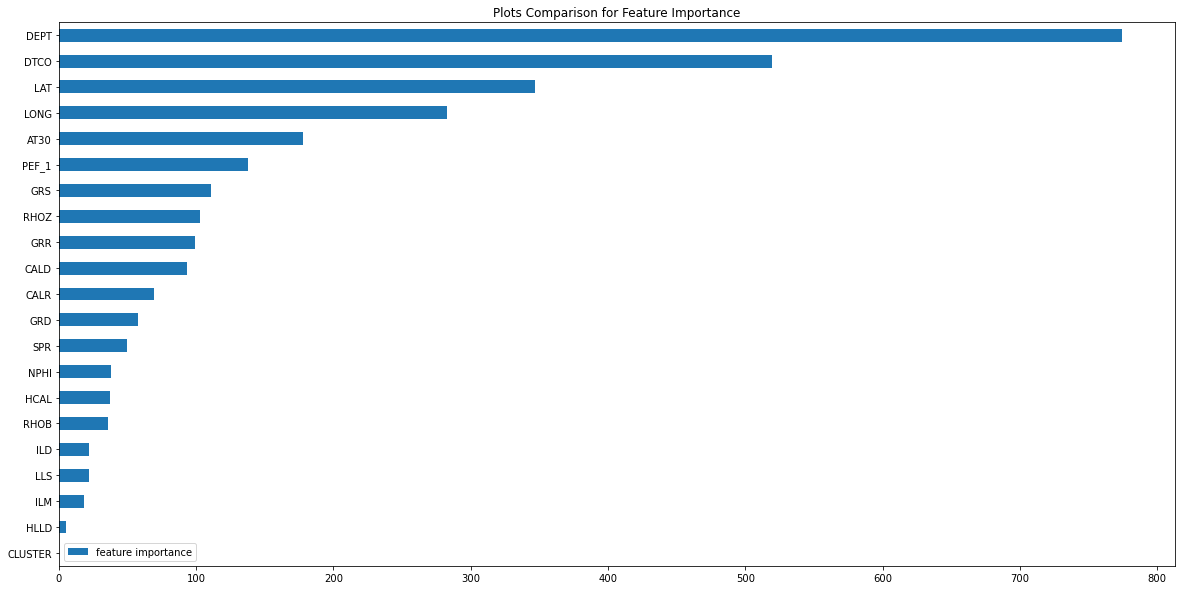

In [83]:
start_time = time.time()

df_labels = y
df_features = X

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'learning_rate': 0.4,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 8,
#     "num_leaves": 128,  
#     "max_bin": 512,
    "num_iterations": 100,
    "n_estimators": 100,
    "seed": 42
}

mod = lgb.LGBMRegressor(**params)
mod.fit(df_features, df_labels)
featimportance=mod.feature_importances_

# summarize feature importance
feature_importance = pd.DataFrame(featimportance, index=df_features.columns, 
                                  columns=['feature importance']).sort_values('feature importance', ascending=True)
# plot feature importance
feature_importance.plot(kind='barh', title='Plots Comparison for Feature Importance', figsize=(20,10))

print("--- %s seconds ---" % (time.time() - start_time))

### 7H. Shuffling the data

In [84]:
X, y = shuffle(X, y, random_state=42)
X_blind, y_blind = shuffle(X_blind, y_blind, random_state=42)

In [85]:
X

,LAT,LONG,DEPT,GRD,CALD,HCAL,CALR,RHOB,RHOZ,NPHI,ILD,ILM,HLLD,LLS,SPR,PEF_1,DTCO,GRR,GRS,AT30,CLUSTER
3023686,5.621285,4.471880,13981.0,0.000000,16.0436,0.0,0.0,2.7306,0.000000,0.000000,41.7654,38.0441,0.0,0.000000,0.0,3.6978,4.223596,4.534747,0.000000,0.000000,1.0
2220884,2.285070,8.141602,9036.5,0.000000,0.0000,0.0,0.0,0.0000,0.957241,0.000000,0.0000,0.0000,0.0,0.000000,0.0,2.7211,0.000000,0.000000,0.000000,0.000000,0.0
2409671,2.146027,5.948632,6005.0,0.000000,0.0000,0.0,0.0,0.0000,0.984435,0.000000,0.0000,0.0000,0.0,0.000000,0.0,4.0160,4.186372,0.000000,0.000000,3.202816,0.0
3481755,2.502285,8.379994,7957.0,4.072479,9.9426,0.0,0.0,0.0000,0.963403,0.000000,0.0000,0.0000,0.0,0.000000,0.0,3.4102,4.019190,0.000000,0.000000,0.000000,0.0
3659912,2.814888,6.662970,3620.0,3.705626,0.0000,0.0,0.0,0.0000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,3.696458,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356330,1.999911,6.164735,4296.0,0.000000,0.0000,0.0,0.0,0.0000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,4.283715,0.000000,4.242086,0.000000,0.0
3511566,4.305102,1.260153,10883.0,0.000000,0.0000,0.0,0.0,0.0000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,1.0
2229084,1.089535,6.558643,893.0,3.989552,10.3739,0.0,0.0,2.3876,0.000000,-2.044847,0.0000,0.0000,0.0,3.627639,0.0,3.1362,4.252987,0.000000,3.937580,0.000000,0.0
2768307,1.947544,7.958986,9588.5,0.000000,0.0000,0.0,0.0,0.0000,0.932440,0.000000,0.0000,0.0000,0.0,0.000000,0.0,2.8475,4.173471,0.000000,0.000000,0.000000,0.0


### 7I. Scaled and transformed the data

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 7J. Train, test, split the data

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 8. Predictions

I used a number of  methods, but ended up using LightGBM almost exclusively because it gave me the best scores and it ran extremely fast versus something like XGBoost or Random Forest.

List of methods used:
- XGBoost
- Random Forest Regressor
- Gradient Boosting Regressor
- ADA Boosting
- Linear Regression
- SVR

### 8A. LightGBM

https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm
    
https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/

Hyperparameter tuning:

https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b

In [88]:
# Timing of LightGBM prediction
start_time = time.time()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'learning_rate': 0.4,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 8,
#     "num_leaves": 128,  
#     "max_bin": 512,
    "num_iterations": 1000,
    "n_estimators": 500,
    "seed": 42
}

gbm = lgb.LGBMRegressor(**params)

gbm.fit(X_train,y_train)

pred_lgb = gbm.predict(X_test)
rmse_lgb = np.sqrt(MSE(y_test,pred_lgb))
r2_lgb = r2_score(y_test, pred_lgb)

print("Test data")
print(rmse_lgb)
print(r2_lgb)
print("--- %s seconds ---" % (time.time() - start_time))

Test data
10.03030270202813
0.9772662352094684
--- 103.84677791595459 seconds ---


In [89]:
# Timing of LightGBM prediction
start_time = time.time()

X_blind_scaled = scaler.transform(X_blind)
y_blind_pred = gbm.predict(X_blind_scaled)
rmse = np.sqrt(MSE(y_blind,y_blind_pred))
r2 = r2_score(y_blind, y_blind_pred)

print("Blind data")
print(rmse)
print(r2)
print("--- %s seconds ---" % (time.time() - start_time))

Blind data
1.028331531817725
0.9990239215265655
--- 0.29005861282348633 seconds ---


The following function just graphs the RMSE and R2 of the test and blind data

In [90]:
def log_scatter(log_data, depth, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(log_data, depth, marker=marker, s=size, label=label)
    plt.ylim(depth.min(), depth.max())
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

No handles with labels found to put in legend.


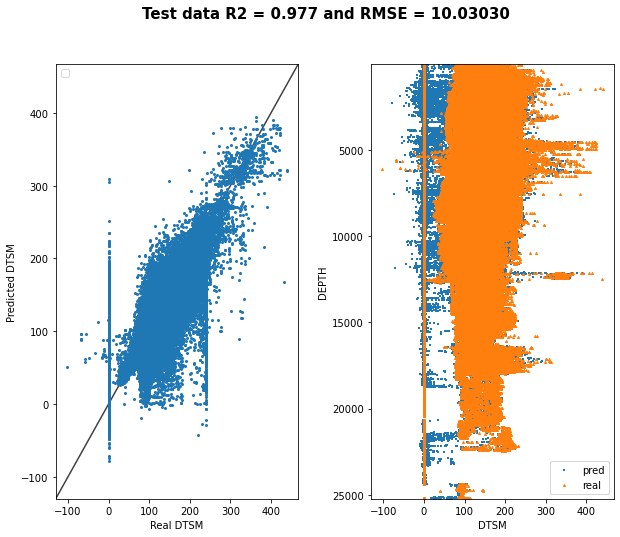

In [91]:
name='DTSM'
Depth = pd.DataFrame(scaler.inverse_transform(X_test), columns=features.columns)['DEPT']
fig = plt.figure(figsize=(10.0, 8.0))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
plt.subplot(121)
log_scatter(y_test, pred_lgb, x_label='Real %s' % name, y_label='Predicted %s' % name)
lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
        ]    
# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.gca().set_aspect('equal')
plt.gca().set_xlim(lims)
plt.gca().set_ylim(lims)
plt.subplot(122)
log_scatter(pred_lgb, Depth, marker='+', label='pred')
log_scatter(y_test, Depth, x_label='%s' % name, y_label='DEPTH', marker='^',alpha=0.5, label='real')
fig.suptitle('Test data R2 = {:.3f} and RMSE = {:.5f}'.format(r2_lgb, rmse_lgb), weight='bold', fontsize=15)
plt.show()

No handles with labels found to put in legend.


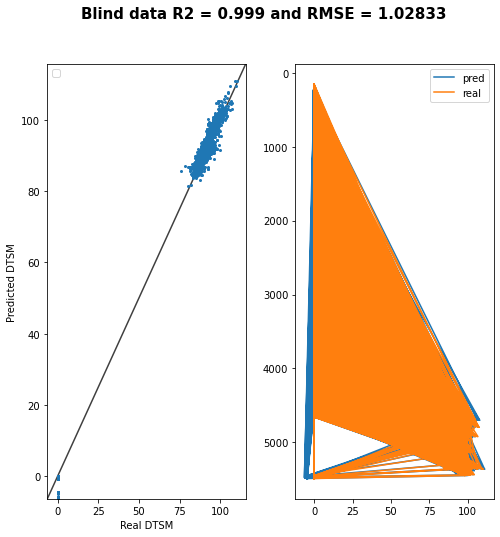

In [92]:
# plotting blind data
fig = plt.figure(figsize=(8.0, 8.0))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
plt.subplot(121)
log_scatter(y_blind, y_blind_pred, x_label='Real %s' % name, y_label='Predicted %s' % name)
lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
        ]    
# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.gca().set_aspect('equal')
plt.gca().set_xlim(lims)
plt.gca().set_ylim(lims)
plt.subplot(122)
plt.plot(y_blind_pred, X_blind.DEPT)#, marker='+', label='pred'
plt.plot(y_blind, X_blind.DEPT)#, x_label='%s' % name, y_label='DEPTH', marker='^',alpha=0.5, label='real'
plt.gca().invert_yaxis()
plt.legend(['pred','real'])
fig.suptitle('Blind data R2 = {:.3f} and RMSE = {:.5f}'.format(r2, rmse), weight='bold', fontsize=15)
plt.show()

## 9. Final Testing

In [93]:
las_test_df = pd.DataFrame()

In [94]:
lastestDic

{'00d02be79f49_TGS.las': <lasio.las.LASFile at 0x1ed181938c8>,
 '0a7822c59487_TGS.las': <lasio.las.LASFile at 0x1ed18187688>,
 '113412eec2a6_TGS.las': <lasio.las.LASFile at 0x1ed1730ea48>,
 '1684cc35f399_TGS.las': <lasio.las.LASFile at 0x1ed18187708>,
 '20372701d5e2_TGS.las': <lasio.las.LASFile at 0x1ed181877c8>,
 '2f96a5f92418_TGS.las': <lasio.las.LASFile at 0x1ed181a5288>,
 '302460e3021a_TGS.las': <lasio.las.LASFile at 0x1ed181aa108>,
 '3369b6f8fb6f_TGS.las': <lasio.las.LASFile at 0x1ed181b5f88>,
 '34a80ab7a5fa_TGS.las': <lasio.las.LASFile at 0x1ed181811c8>,
 '63250f7d463b_TGS.las': <lasio.las.LASFile at 0x1ed18202508>,
 '638f2cc65681_TGS.las': <lasio.las.LASFile at 0x1ed18202548>,
 '7595ba9fb314_TGS.las': <lasio.las.LASFile at 0x1ed1820c8c8>,
 '84c5fb9cc880_TGS.las': <lasio.las.LASFile at 0x1ed18211c08>,
 '8e37531ba266_TGS.las': <lasio.las.LASFile at 0x1ed18220fc8>,
 '94c1f5cae85c_TGS.las': <lasio.las.LASFile at 0x1ed18218f48>,
 'ae16a9f64878_TGS.las': <lasio.las.LASFile at 0x1ed182

### 9A. Renaming data columns as required

In [95]:
# Timing of dataframe creation
start_time = time.time()

for well in lastestDic:
    lastest = lastestDic[well]
    lastestdf = lastest.df()
    lastestdf.reset_index(inplace=True)
    
    for col in lasdf.columns:
        if col in list(renaminglist.keys()):
            lastestdf = lastestdf.rename(columns = {col:renaminglist[col]})

    if all(elem in lastestdf.columns for elem in ['PEFZ', 'PEF']):
#         print('PEF and PEFZ present')
        lastestdf['PEF_1'] = ""
        lastestdf['PEF_1'] = lastestdf.apply(lambda x: x['PEFZ'] if pd.isnull(x['PEF']) else x['PEF'], axis=1)
    elif 'PEFZ' in lastestdf.columns:
#         print('PEFZ present')
        lastestdf['PEF_1'] = ""
        lastestdf['PEF_1'] = lastestdf.apply(lambda x: x['PEFZ'], axis=1)
    elif 'PEF' in lastestdf.columns:
#         print('PEF present')
        lastestdf['PEF_1'] = ""
        lastestdf['PEF_1'] = lastestdf.apply(lambda x: x['PEF'], axis=1)
    else:
#         print('None present')
        lastestdf['PEF_1'] = np.nan
    
    lastestdf = lastestdf[lastestdf.columns.intersection(important_cols)]
    lastestdf.insert(loc=0, column='WELL', value=well)
    lastestdf.insert(loc=1, column='LAT', value=lastest.well['SLAT'].value)
    lastestdf.insert(loc=2, column='LONG', value=lastest.well['SLON'].value)
    las_test_df = pd.concat([las_test_df, lastestdf], ignore_index=True, sort=False)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.0048553943634033 seconds ---


In [96]:
las_test_df

,WELL,LAT,LONG,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL
0,00d02be79f49_TGS.las,6.041330,3.155431,9912.0,0.1057,-0.2491,6.2363,1.8771,49.1883,1900.9751,1979.1610,12.2620,1.1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00d02be79f49_TGS.las,6.041330,3.155431,9912.5,0.0925,-0.2487,6.2481,1.8989,56.5820,1990.3184,1985.7312,5.1245,0.2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00d02be79f49_TGS.las,6.041330,3.155431,9913.0,0.0818,-0.2482,6.2844,2.0063,68.5213,1988.7848,1992.3221,-4.5998,0.2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00d02be79f49_TGS.las,6.041330,3.155431,9913.5,0.0791,-0.2478,6.6677,2.0603,78.8782,1987.2515,1975.0984,-14.8317,1.0988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00d02be79f49_TGS.las,6.041330,3.155431,9914.0,0.0857,-0.2474,7.2943,2.1871,83.4741,1985.7203,1621.4595,-17.6811,7.7941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,230.6033,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN
148002,ff7845ea074d_TGS.las,7.011406,4.141898,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,230.6022,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN
148003,ff7845ea074d_TGS.las,7.011406,4.141898,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,230.6058,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN
148004,ff7845ea074d_TGS.las,7.011406,4.141898,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,230.6094,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN


### 9B. K-Means Lat/Long Clustering

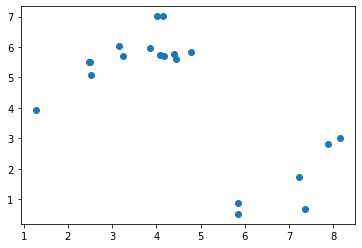

,WELL,LAT,LONG
0,00d02be79f49_TGS.las,6.041330,3.155431
1,0a7822c59487_TGS.las,0.673955,7.358267
2,113412eec2a6_TGS.las,5.522046,2.485059
3,1684cc35f399_TGS.las,3.941460,1.275738
4,20372701d5e2_TGS.las,5.703008,3.252864
5,2f96a5f92418_TGS.las,5.722324,4.092011
6,302460e3021a_TGS.las,7.005066,4.024214
7,3369b6f8fb6f_TGS.las,2.824407,7.875414
8,34a80ab7a5fa_TGS.las,5.499376,2.504759
9,63250f7d463b_TGS.las,3.017278,8.157734


,WELL,LAT,LONG,CLUSTER
0,00d02be79f49_TGS.las,6.041330,3.155431,1
1,0a7822c59487_TGS.las,0.673955,7.358267,0
2,113412eec2a6_TGS.las,5.522046,2.485059,1
3,1684cc35f399_TGS.las,3.941460,1.275738,1
4,20372701d5e2_TGS.las,5.703008,3.252864,1
5,2f96a5f92418_TGS.las,5.722324,4.092011,1
6,302460e3021a_TGS.las,7.005066,4.024214,1
7,3369b6f8fb6f_TGS.las,2.824407,7.875414,0
8,34a80ab7a5fa_TGS.las,5.499376,2.504759,1
9,63250f7d463b_TGS.las,3.017278,8.157734,0


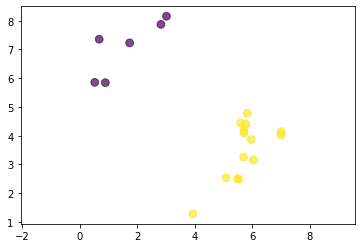

In [97]:
Lat_test = []
Lon_test = []
Well_test = []
for filename in lastestDic:
    las_test = lastestDic[filename]
    Lat_test.append(las_test.well['SLAT'].value)
    Lon_test.append(las_test.well['SLON'].value)
    Well_test.append(filename)
    
plt.scatter(x=Lon_test,y=Lat_test)
plt.show()

LatLong_test_df = pd.DataFrame(
    {'WELL': Well_test,
     'LAT': Lat_test,
     'LONG': Lon_test
    })

display(LatLong_test_df)

X_cluster_test = LatLong_test_df.drop(['WELL'], axis=1).values

labels_test = kmeans.fit_predict(X_cluster_test)

cluster_test_df = LatLong_test_df.join(pd.DataFrame(labels_test, columns=['CLUSTER']))
cluster_test_df  = cluster_test_df .astype({"CLUSTER":'category'}) 

ax = plt.gca()
ax.axis('equal')
ax.scatter(X_cluster_test[:, 0], X_cluster_test[:, 1], c = labels_test, s=60, cmap='viridis', zorder=1, alpha = 0.7)

display(cluster_test_df)

In [98]:
las_test_df

,WELL,LAT,LONG,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL
0,00d02be79f49_TGS.las,6.041330,3.155431,9912.0,0.1057,-0.2491,6.2363,1.8771,49.1883,1900.9751,1979.1610,12.2620,1.1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00d02be79f49_TGS.las,6.041330,3.155431,9912.5,0.0925,-0.2487,6.2481,1.8989,56.5820,1990.3184,1985.7312,5.1245,0.2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00d02be79f49_TGS.las,6.041330,3.155431,9913.0,0.0818,-0.2482,6.2844,2.0063,68.5213,1988.7848,1992.3221,-4.5998,0.2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00d02be79f49_TGS.las,6.041330,3.155431,9913.5,0.0791,-0.2478,6.6677,2.0603,78.8782,1987.2515,1975.0984,-14.8317,1.0988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00d02be79f49_TGS.las,6.041330,3.155431,9914.0,0.0857,-0.2474,7.2943,2.1871,83.4741,1985.7203,1621.4595,-17.6811,7.7941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,230.6033,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN
148002,ff7845ea074d_TGS.las,7.011406,4.141898,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,230.6022,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN
148003,ff7845ea074d_TGS.las,7.011406,4.141898,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,230.6058,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN
148004,ff7845ea074d_TGS.las,7.011406,4.141898,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,230.6094,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN


In [99]:
las_test_df = las_test_df.merge(cluster_test_df, how='inner', on=['WELL', 'LAT', 'LONG'])

In [100]:
las_test_df

,WELL,LAT,LONG,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL,CLUSTER
0,00d02be79f49_TGS.las,6.041330,3.155431,9912.0,0.1057,-0.2491,6.2363,1.8771,49.1883,1900.9751,1979.1610,12.2620,1.1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,00d02be79f49_TGS.las,6.041330,3.155431,9912.5,0.0925,-0.2487,6.2481,1.8989,56.5820,1990.3184,1985.7312,5.1245,0.2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,00d02be79f49_TGS.las,6.041330,3.155431,9913.0,0.0818,-0.2482,6.2844,2.0063,68.5213,1988.7848,1992.3221,-4.5998,0.2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,00d02be79f49_TGS.las,6.041330,3.155431,9913.5,0.0791,-0.2478,6.6677,2.0603,78.8782,1987.2515,1975.0984,-14.8317,1.0988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,00d02be79f49_TGS.las,6.041330,3.155431,9914.0,0.0857,-0.2474,7.2943,2.1871,83.4741,1985.7203,1621.4595,-17.6811,7.7941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,230.6033,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN,1
148002,ff7845ea074d_TGS.las,7.011406,4.141898,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,230.6022,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN,1
148003,ff7845ea074d_TGS.las,7.011406,4.141898,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,230.6058,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN,1
148004,ff7845ea074d_TGS.las,7.011406,4.141898,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,230.6094,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN,1


### 9C. Create test data copy

In [101]:
las_test_df1 = las_test_df.copy()

### 9D. Removing outliers

In [102]:
las_test_df1['GRS'] = outlier_removal(las_test_df1['GRS'], operator.gt, 200, 200)
las_test_df1['GRD'] = outlier_removal(las_test_df1['GRD'], operator.gt, 200, 200)
las_test_df1['GRR'] = outlier_removal(las_test_df1['GRR'], operator.gt, 200, 200)
las_test_df1['ILM'] = outlier_removal(las_test_df1['ILM'], operator.gt, 200, 200)
las_test_df1['ILD'] = outlier_removal(las_test_df1['ILD'], operator.gt, 200, 200)
las_test_df1['HLLD'] = outlier_removal(las_test_df1['HLLD'], operator.gt, 5000, 5000)
las_test_df1['LLS'] = outlier_removal(las_test_df1['LLS'], operator.gt, 1000, 1000)

Before outlier removal for GRS
GRS Min 2.6262
GRS Max 261.7505
Number of GRS outliers: 161 

After outlier removal for GRS
GRS Min 2.6262
GRS Max 200.0
Before outlier removal for GRD
GRD Min 1.3493
GRD Max 1336.0282
Number of GRD outliers: 1006 

After outlier removal for GRD
GRD Min 1.3493
GRD Max 200.0
Before outlier removal for GRR
GRR Min 2.9888
GRR Max 300.0
Number of GRR outliers: 460 

After outlier removal for GRR
GRR Min 2.9888
GRR Max 200.0
Before outlier removal for ILM
ILM Min 1.0726
ILM Max 2097.9158
Number of ILM outliers: 11575 

After outlier removal for ILM
ILM Min 1.0726
ILM Max 200.0
Before outlier removal for ILD
ILD Min 0.6107
ILD Max 2084.2266
Number of ILD outliers: 13231 

After outlier removal for ILD
ILD Min 0.6107
ILD Max 200.0
Before outlier removal for HLLD
HLLD Min 6.4671
HLLD Max 226.5095
Number of HLLD outliers: 0 

After outlier removal for HLLD
HLLD Min 6.4671
HLLD Max 226.5095
Before outlier removal for LLS
LLS Min 0.2519
LLS Max 10652.4903
Number of 

In [103]:
las_test_df1

,WELL,LAT,LONG,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL,CLUSTER
0,00d02be79f49_TGS.las,6.041330,3.155431,9912.0,0.1057,-0.2491,6.2363,1.8771,49.1883,200.0,200.0,12.2620,1.1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,00d02be79f49_TGS.las,6.041330,3.155431,9912.5,0.0925,-0.2487,6.2481,1.8989,56.5820,200.0,200.0,5.1245,0.2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,00d02be79f49_TGS.las,6.041330,3.155431,9913.0,0.0818,-0.2482,6.2844,2.0063,68.5213,200.0,200.0,-4.5998,0.2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,00d02be79f49_TGS.las,6.041330,3.155431,9913.5,0.0791,-0.2478,6.6677,2.0603,78.8782,200.0,200.0,-14.8317,1.0988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,00d02be79f49_TGS.las,6.041330,3.155431,9914.0,0.0857,-0.2474,7.2943,2.1871,83.4741,200.0,200.0,-17.6811,7.7941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,200.0,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN,1
148002,ff7845ea074d_TGS.las,7.011406,4.141898,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,200.0,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN,1
148003,ff7845ea074d_TGS.las,7.011406,4.141898,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,200.0,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN,1
148004,ff7845ea074d_TGS.las,7.011406,4.141898,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,200.0,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN,1


In [104]:
# las_test_df1[las_test_df1.columns[~las_test_df1.columns.isin(['WELL', 'LAT', 'LONG', 'CLUSTER'])]]

### 9E. Log Transformation

In [105]:
for column in las_test_df1[['DTCO', 'GRD', 'SPR', 'RHOZ', 
                      'NPHI', 'HLLD', 'LLS',
                      'GRR', 'GRS', 'AT30'
                      ]]:
    las_test_df1[column] = np.log(las_test_df1[column])

### 9F. Treating infinity/negative infinity values

In [106]:
las_test_df1 = las_test_df1.replace([np.inf, -np.inf], 0)

### 9G. Imputing

In [107]:
las_test_df1 = well_nan_remove(las_test_df1)

In [108]:
las_test_df1

,LAT,LONG,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL,CLUSTER
0,6.041330,3.155431,9912.0,0.1057,-0.2491,6.2363,1.8771,3.895656,200.0,200.0,2.506505,1.1093,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0
1,6.041330,3.155431,9912.5,0.0925,-0.2487,6.2481,1.8989,4.035691,200.0,200.0,1.634033,0.2062,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0
2,6.041330,3.155431,9913.0,0.0818,-0.2482,6.2844,2.0063,4.227145,200.0,200.0,0.000000,0.2538,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0
3,6.041330,3.155431,9913.5,0.0791,-0.2478,6.6677,2.0603,4.367905,200.0,200.0,0.000000,1.0988,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0
4,6.041330,3.155431,9914.0,0.0857,-0.2474,7.2943,2.1871,4.424536,200.0,200.0,0.000000,7.7941,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,7.011406,4.141898,8817.0,0.0100,0.0539,7.7050,2.6322,0.000000,0.0,0.0,0.000000,0.0000,3.933272,2.4312,0.0,0.0,5.298317,5.289315,0.0,0.0,0.0,0.0,0.0,4167.3564,4089.7834,0.0,0.0,0.0,0.0,0.0,3809.6677,0.0,1.0
148002,7.011406,4.141898,8817.5,0.0105,0.0715,7.5904,2.6145,0.000000,0.0,0.0,0.000000,0.0000,3.943739,2.4303,0.0,0.0,5.298317,5.289330,0.0,0.0,0.0,0.0,0.0,4160.8433,4092.9836,0.0,0.0,0.0,0.0,0.0,3845.6101,0.0,1.0
148003,7.011406,4.141898,8818.0,0.0108,0.0916,7.4601,2.5828,0.000000,0.0,0.0,0.000000,0.0000,3.949993,2.3676,0.0,0.0,5.298317,5.289344,0.0,0.0,0.0,0.0,0.0,4166.6270,4058.7727,0.0,0.0,0.0,0.0,0.0,3755.7061,0.0,1.0
148004,7.011406,4.141898,8818.5,0.0108,0.1103,7.3454,2.5610,0.000000,0.0,0.0,0.000000,0.0000,3.954659,2.2730,0.0,0.0,5.298317,5.289358,0.0,0.0,0.0,0.0,0.0,4177.0312,4006.2107,0.0,0.0,0.0,0.0,0.0,3675.4641,0.0,1.0


In [109]:
X_test_group = las_test_df1

In [110]:
X_test_group.fillna(0, inplace=True)

In [111]:
X_test_group = X_test_group[final_vars1]

### 9H. Scale and Transform

In [112]:
open_test_features = scaler.transform(X_test_group)

### 9I. Prediction

In [113]:
test_prediction = gbm.predict(open_test_features)

In [114]:
display(test_prediction)

array([ 0.18131908,  0.17951134, -0.26821607, ..., 90.23334239,
       91.36042362, 91.36042362])

In [115]:
las_test_df2 = las_test_df.copy()
las_test_df2.insert(loc=3, column='DTSM', value=test_prediction.tolist())

In [116]:
las_test_df2

,WELL,LAT,LONG,DTSM,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL,CLUSTER
0,00d02be79f49_TGS.las,6.041330,3.155431,0.181319,9912.0,0.1057,-0.2491,6.2363,1.8771,49.1883,1900.9751,1979.1610,12.2620,1.1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,00d02be79f49_TGS.las,6.041330,3.155431,0.179511,9912.5,0.0925,-0.2487,6.2481,1.8989,56.5820,1990.3184,1985.7312,5.1245,0.2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,00d02be79f49_TGS.las,6.041330,3.155431,-0.268216,9913.0,0.0818,-0.2482,6.2844,2.0063,68.5213,1988.7848,1992.3221,-4.5998,0.2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,00d02be79f49_TGS.las,6.041330,3.155431,-0.251039,9913.5,0.0791,-0.2478,6.6677,2.0603,78.8782,1987.2515,1975.0984,-14.8317,1.0988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,00d02be79f49_TGS.las,6.041330,3.155431,-0.271256,9914.0,0.0857,-0.2474,7.2943,2.1871,83.4741,1985.7203,1621.4595,-17.6811,7.7941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,51.500118,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,230.6033,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN,1
148002,ff7845ea074d_TGS.las,7.011406,4.141898,56.602935,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,230.6022,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN,1
148003,ff7845ea074d_TGS.las,7.011406,4.141898,90.233342,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,230.6058,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN,1
148004,ff7845ea074d_TGS.las,7.011406,4.141898,91.360424,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,230.6094,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN,1


### 9J. Sample predicted well and DTSM log

,WELL,LAT,LONG,DTSM,DEPT,NPHI_LS,DRHO,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,DTCO,PEF_1,CALR,DPHZ_LS,GRD,GRS,HDRA,HLLD,LLS,RHOZ,RXOZ,TEND,TENS,TNPH_LS,NPHI,AT90,AT30,AT10,TENR,HCAL,CLUSTER
144335,ff7845ea074d_TGS.las,7.011406,4.141898,92.422823,6984.0,NaN,NaN,NaN,NaN,12.2273,43.0457,35.3551,-105.9360,90.6969,53.2193,NaN,NaN,NaN,NaN,8.3856,NaN,NaN,NaN,NaN,NaN,NaN,3092.9297,NaN,NaN,NaN,NaN,NaN,2828.0667,NaN,1
144336,ff7845ea074d_TGS.las,7.011406,4.141898,89.654230,6984.5,NaN,NaN,NaN,NaN,9.8619,43.9756,34.5501,-106.2947,88.4926,52.4380,NaN,NaN,NaN,NaN,9.3071,NaN,NaN,NaN,NaN,NaN,NaN,3089.7869,NaN,NaN,NaN,NaN,NaN,2826.2815,NaN,1
144337,ff7845ea074d_TGS.las,7.011406,4.141898,97.907775,6985.0,NaN,NaN,NaN,NaN,8.9463,44.6007,33.7072,-106.8272,89.2624,51.6567,NaN,NaN,NaN,NaN,9.5639,NaN,NaN,NaN,NaN,NaN,NaN,3086.6443,NaN,NaN,NaN,NaN,NaN,2836.6003,NaN,1
144338,ff7845ea074d_TGS.las,7.011406,4.141898,97.613528,6985.5,NaN,NaN,NaN,NaN,9.1174,44.8237,34.0908,-106.7741,92.5508,51.4208,NaN,NaN,NaN,NaN,9.0939,NaN,NaN,NaN,NaN,NaN,NaN,3083.5015,NaN,NaN,NaN,NaN,NaN,2847.0264,NaN,1
144339,ff7845ea074d_TGS.las,7.011406,4.141898,97.613528,6986.0,NaN,NaN,NaN,NaN,9.1703,44.8582,34.3955,-106.7001,95.8585,51.2788,NaN,NaN,NaN,NaN,8.8256,NaN,NaN,NaN,NaN,NaN,NaN,3080.3586,NaN,NaN,NaN,NaN,NaN,2857.4524,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,7.011406,4.141898,51.500118,8817.0,0.0100,0.0539,7.7050,2.6322,NaN,NaN,NaN,NaN,NaN,51.0738,2.4312,NaN,NaN,230.6033,198.2077,NaN,NaN,NaN,NaN,NaN,4167.3564,4089.7834,NaN,NaN,NaN,NaN,NaN,3809.6677,NaN,1
148002,ff7845ea074d_TGS.las,7.011406,4.141898,56.602935,8817.5,0.0105,0.0715,7.5904,2.6145,NaN,NaN,NaN,NaN,NaN,51.6112,2.4303,NaN,NaN,230.6022,198.2105,NaN,NaN,NaN,NaN,NaN,4160.8433,4092.9836,NaN,NaN,NaN,NaN,NaN,3845.6101,NaN,1
148003,ff7845ea074d_TGS.las,7.011406,4.141898,90.233342,8818.0,0.0108,0.0916,7.4601,2.5828,NaN,NaN,NaN,NaN,NaN,51.9350,2.3676,NaN,NaN,230.6058,198.2134,NaN,NaN,NaN,NaN,NaN,4166.6270,4058.7727,NaN,NaN,NaN,NaN,NaN,3755.7061,NaN,1
148004,ff7845ea074d_TGS.las,7.011406,4.141898,91.360424,8818.5,0.0108,0.1103,7.3454,2.5610,NaN,NaN,NaN,NaN,NaN,52.1779,2.2730,NaN,NaN,230.6094,198.2162,NaN,NaN,NaN,NaN,NaN,4177.0312,4006.2107,NaN,NaN,NaN,NaN,NaN,3675.4641,NaN,1


array(['ff7845ea074d_TGS.las'], dtype=object)

Text(0.5, 0, 'GRD')

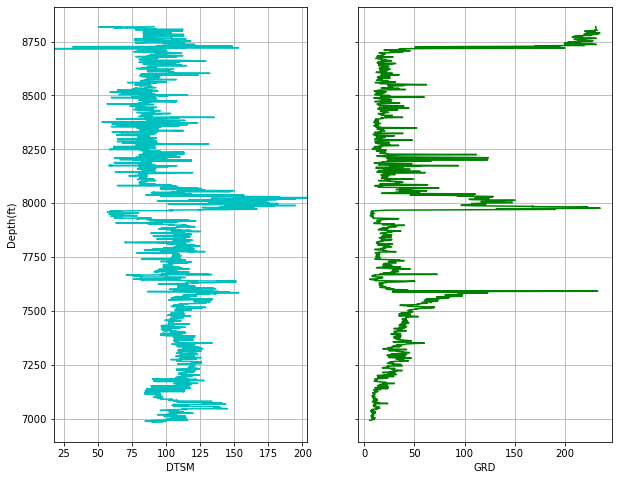

In [117]:
logs = las_test_df2[las_test_df2['WELL'] == 'ff7845ea074d_TGS.las']
display(logs)
display(logs['WELL'].unique())


f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), sharey=True)
ax[0].plot(logs.DTSM, logs.DEPT, color='c')
ax[1].plot(logs.GRD, logs.DEPT, color='green')
for i in range(len(ax)):
    #ax[i].set_ylim(logs.DEPT[0], logs.DEPT[-1])
    ax[i].invert_yaxis()
    ax[i].grid()

ax[0].set_xlabel("DTSM")
ax[0].set_xlim(logs.DTSM.min(), logs.DTSM.max())
ax[0].set_ylabel("Depth(ft)")
ax[1].set_xlabel("GRD")
#ax[1].set_xlim(logs.GRD.min(), logs.GRD.max())

### 9K. Final Excel Export and Submission

In [118]:
for well in las_test_df2['WELL'].unique()[:]:
    #display(las_test_df2[las_test_df2['WELL'] == well]['DTSM'].shape)
    temp_df = pd.DataFrame(columns=['Depth','DTSM'])
    temp_df['Depth'] = las_test_df2[las_test_df2['WELL'] == well]['DEPT']
    temp_df['DTSM'] = las_test_df2[las_test_df2['WELL'] == well]['DTSM']
    temp_df.reset_index(drop=True, inplace=True)
    well_exp = well.rstrip('.las')
    display(well_exp)
    display(temp_df)
    temp_df.to_excel(well_exp + ".xlsx", index=False)  

'00d02be79f49_TGS'

,Depth,DTSM
0,9912.0,0.181319
1,9912.5,0.179511
2,9913.0,-0.268216
3,9913.5,-0.251039
4,9914.0,-0.271256
...,...,...
1302,10563.0,17.224075
1303,10563.5,16.662131
1304,10564.0,16.662131
1305,10564.5,16.662131


'0a7822c59487_TGS'

,Depth,DTSM
0,5868.0,24.745840
1,5868.5,24.166181
2,5869.0,24.704998
3,5869.5,32.274798
4,5870.0,32.000647
...,...,...
5130,8433.0,129.260782
5131,8433.5,129.638696
5132,8434.0,130.070700
5133,8434.5,130.070700


'113412eec2a6_TGS'

,Depth,DTSM
0,5000.0,145.685644
1,5000.5,141.633390
2,5001.0,139.698205
3,5001.5,149.041607
4,5002.0,146.879270
...,...,...
12841,11420.5,88.675635
12842,11421.0,88.843154
12843,11421.5,91.632040
12844,11422.0,-3.287418


'1684cc35f399_TGS'

,Depth,DTSM
0,5994.0,131.704845
1,5994.5,125.736864
2,5995.0,122.828431
3,5995.5,107.166216
4,5996.0,99.347792
...,...,...
13250,12619.0,109.395555
13251,12619.5,106.725163
13252,12620.0,106.252454
13253,12620.5,109.858265


'20372701d5e2_TGS'

,Depth,DTSM
0,13105.0,137.045747
1,13105.5,168.080870
2,13106.0,167.787358
3,13106.5,167.236721
4,13107.0,167.200569
...,...,...
2142,14176.0,189.602953
2143,14176.5,189.602953
2144,14177.0,189.602953
2145,14177.5,189.602953


'2f96a5f92418_TGS'

,Depth,DTSM
0,12787.5,-6.856946
1,12788.0,-6.734552
2,12788.5,99.099668
3,12789.0,98.755262
4,12789.5,97.547472
...,...,...
3492,14533.5,112.390685
3493,14534.0,107.110731
3494,14534.5,106.563988
3495,14535.0,102.953945


'302460e3021a_TGS'

,Depth,DTSM
0,586.0,109.254547
1,586.5,127.386345
2,587.0,161.150556
3,587.5,217.480298
4,588.0,218.964256
...,...,...
10740,6064.0,98.111542
10741,6064.5,93.643619
10742,6065.0,94.229786
10743,6065.5,92.728981


'3369b6f8fb6f_TGS'

,Depth,DTSM
0,2961.0,90.428528
1,2961.5,91.376260
2,2962.0,91.608688
3,2962.5,95.244152
4,2963.0,97.689520
...,...,...
1396,3659.0,93.439106
1397,3659.5,93.079014
1398,3660.0,93.192116
1399,3660.5,92.195065


'34a80ab7a5fa_TGS'

,Depth,DTSM
0,7887.0,125.577560
1,7887.5,126.718348
2,7888.0,124.144357
3,7888.5,121.055604
4,7889.0,116.230083
...,...,...
2014,8894.0,132.740747
2015,8894.5,131.708566
2016,8895.0,130.510096
2017,8895.5,131.101988


'63250f7d463b_TGS'

,Depth,DTSM
0,5241.0,94.205584
1,5241.5,106.621303
2,5242.0,107.040084
3,5242.5,104.806938
4,5243.0,109.748737
...,...,...
13878,12180.0,148.579119
13879,12180.5,155.845493
13880,12181.0,225.378386
13881,12181.5,208.225076


'638f2cc65681_TGS'

,Depth,DTSM
0,5477.0,108.998391
1,5477.5,109.543644
2,5478.0,109.809736
3,5478.5,108.046111
4,5479.0,105.405646
...,...,...
1732,6343.0,151.823128
1733,6343.5,151.823128
1734,6344.0,145.239626
1735,6344.5,145.794585


'7595ba9fb314_TGS'

,Depth,DTSM
0,10398.0,37.797751
1,10398.5,37.953589
2,10399.0,38.681228
3,10399.5,38.681858
4,10400.0,36.270755
...,...,...
1888,11342.0,91.336211
1889,11342.5,81.343414
1890,11343.0,81.978181
1891,11343.5,90.921853


'84c5fb9cc880_TGS'

,Depth,DTSM
0,16002.0,143.268186
1,16002.5,139.465260
2,16003.0,137.711138
3,16003.5,139.821012
4,16004.0,139.821012
...,...,...
1286,16648.0,134.979185
1287,16648.5,138.010213
1288,16649.0,133.159397
1289,16649.5,133.159397


'8e37531ba266_TGS'

,Depth,DTSM
0,2313.0,92.220177
1,2313.5,93.595442
2,2314.0,97.152194
3,2314.5,97.753170
4,2315.0,97.405941
...,...,...
5026,4826.0,85.878081
5027,4826.5,85.878081
5028,4827.0,85.878081
5029,4827.5,-2.504162


'94c1f5cae85c_TGS'

,Depth,DTSM
0,16900.0,143.947175
1,16900.5,124.158822
2,16901.0,106.276546
3,16901.5,98.179930
4,16902.0,104.818002
...,...,...
16921,25396.0,104.100562
16922,25396.5,104.709511
16923,25397.0,103.605922
16924,25397.5,103.786156


'ae16a9f64878_TGS'

,Depth,DTSM
0,5460.0,165.141132
1,5460.5,165.141132
2,5461.0,163.974535
3,5461.5,163.974535
4,5462.0,163.587692
...,...,...
21673,16614.0,148.370207
21674,16614.5,144.607342
21675,16615.0,166.598741
21676,16615.5,167.255369


'ed48bda2217f_TGS'

,Depth,DTSM
0,3085.0,88.202505
1,3085.5,88.784996
2,3086.0,89.776326
3,3086.5,76.026716
4,3087.0,79.846020
...,...,...
24117,15153.0,144.222612
24118,15153.5,134.013436
24119,15154.0,133.239826
24120,15154.5,127.795375


'eed1e9537976_TGS'

,Depth,DTSM
0,7997.0,110.482842
1,7997.5,120.343563
2,7998.0,120.226019
3,7998.5,118.107932
4,7999.0,112.396873
...,...,...
3952,9973.0,129.450138
3953,9973.5,126.156611
3954,9974.0,124.229374
3955,9974.5,123.354130


'fca03aa6acde_TGS'

,Depth,DTSM
0,10797.0,83.642377
1,10797.5,73.549606
2,10798.0,74.872362
3,10798.5,74.704842
4,10799.0,81.938617
...,...,...
1460,11527.0,92.730116
1461,11527.5,92.531853
1462,11528.0,93.794376
1463,11528.5,93.863043


'ff7845ea074d_TGS'

,Depth,DTSM
0,6984.0,92.422823
1,6984.5,89.654230
2,6985.0,97.907775
3,6985.5,97.613528
4,6986.0,97.613528
...,...,...
3666,8817.0,51.500118
3667,8817.5,56.602935
3668,8818.0,90.233342
3669,8818.5,91.360424


### 10. Environment/Version Control and Information

In [119]:
!conda env export > environment_spegcsmlchallenge_2021_02_25.yml